In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit

In [74]:
# User-defined PATH TO DATA REPOSITORY
litrev_dir = '/Users/Dana/Desktop/Jupyter/WISC/NaturalCommunity/lit_review_data_supp/' 


In [39]:
pump_range = []
pump_rates = []
for filename in os.listdir(litrev_dir +'pump_impacts'):
    
    try:
        pump_range = pump_range + [float(filename[:-12])]
        pump_rates = pump_rates + [filename[:-12]]
    except:
        print(filename[:-12])
        
air_temp = pd.read_csv(litrev_dir +'streamflow_data/temp_data_noaa.csv')[['DATE','TMAX']].set_index('DATE')
air_temp = air_temp.reset_index()
air_temp['DATE'] = pd.to_datetime(air_temp.DATE)
air_temp = air_temp.set_index('DATE')

In [8]:
# https://github.com/dadelforge/baseflow-separation/blob/master/physep/hysep.py
from scipy.ndimage.filters import minimum_filter1d, generic_filter

def fixed_interval_filter(ts, size):
    """USGS HYSEP fixed interval method
    
    The USGS HYSEP fixed interval method as described in `Sloto & Crouse, 1996`_.
    
    .. _Slot & Crouse, 1996:
        Sloto, Ronald A., and Michele Y. Crouse. “HYSEP: A Computer Program for Streamflow Hydrograph Separation and 
        Analysis.” USGS Numbered Series. Water-Resources Investigations Report. Geological Survey (U.S.), 1996. 
        http://pubs.er.usgs.gov/publication/wri964040.
    
    :param size: 
    :param ts: 
    :return: 
    """
    intervals = np.arange(len(ts)) // size
    baseflow = pd.Series(data=ts.groupby(intervals).transform('min'), index=ts.index)
    quickflow = ts - baseflow

    baseflow.name = 'baseflow'
    quickflow.name = 'quickflow'

    return baseflow, quickflow



In [6]:
# method to find break in slope and calculate trends on each side of break
# written by David Dralle

def func_broken_stick(x,threshold,b1,b2,a1):
    # a1, b1 are slope and intercept for left curve
    # b2 is slope for right curve
    # intercept on right curve is determined by the intersection constraint
    a2 = (b1*threshold - b2*threshold + a1)
    return np.where(x<threshold, b1*x+a1, b2*x+a2)

def broken_stick_fit(x, y, 
                    threshold_lower_percentile_bound=0,
                    threshold_upper_percentile_bound=100, 
                    slope_left_lower = -np.inf, 
                    slope_left_upper = np.inf,
                    slope_right_lower = -np.inf,
                    slope_right_upper = np.inf
                    ):
    """
    @desc:
    Fits broken stick, with constraints if desired. Note, if using for CQ power law fits, data should first
    be log-transformed.
    
    @params:
    threshold_upper_percentile: upper bound on possible thresholds determined through a percentile on the x data
    threshold_lower_percentile: lower bound on possible thresholds determined through a percentile on the x data
    slope_left_lower: lower constraint on left slope
    slope_left_upper: upper constraint on left slope
    slope_right_lower: lower constraint on right slope
    slope_right_upper: upper constraint on right slope
    
    @returns:
    popt: fitted broken stick paramters as a list
        [threshold: threshold for slope break, 
        b1: slope on left line, 
        b2: slope on right line,
        a1: intercept on left line]
        Note that if the curves intersect, the intercept on the right curve is constrained by the other fits
        a2 = (b1*threshold - b2*threshold + a1)
    standard_errors: standard errors for the fitted parameters
    """

    
    popt_temp, pcov_temp = curve_fit(func_broken_stick, x, y, 
                                    bounds = [(np.percentile(x,threshold_lower_percentile_bound), slope_left_lower, slope_right_lower, -np.inf), 
                                              (np.percentile(x,threshold_upper_percentile_bound), slope_left_upper, slope_right_upper, np.inf)
                                             ]
                                   )
    standard_errors = np.sqrt(np.diag(pcov_temp))
    return popt_temp, standard_errors

In [10]:
def calc_season_dates(temp):
    spring_check = temp[~(temp.isna())].loc[pd.to_datetime('1-1-1999'):pd.to_datetime('4-1-1999')]
    spring_check = spring_check[np.isfinite(spring_check)]
    popt_spring, error = broken_stick_fit(list(range(len(spring_check))),
                    spring_check)
    [threshold, b1, b2, a1] = popt_spring
    spring_start_date = (spring_check.index.values[int(round(threshold))])
    summer_check = temp[~(temp.isna())].loc[pd.to_datetime('5-1-1999'):pd.to_datetime('8-1-1999')]
    summer_check = summer_check[np.isfinite(summer_check)]
    popt_summer, error = broken_stick_fit(list(range(len(summer_check))),
                    summer_check)
    [threshold, b1, b2, a1] = popt_summer
    summer_start_date = (summer_check.index.values[int(round(threshold))])
    fall_check = temp[~(temp.isna())].loc[pd.to_datetime('7-1-1999'):pd.to_datetime('11-15-1999')]
    fall_check = fall_check[np.isfinite(fall_check)]
    popt_fall, error = broken_stick_fit(list(range(len(fall_check))),
                    fall_check)
    [threshold, b1, b2, a1] = popt_fall
    fall_start_date = (fall_check.index.values[int(round(threshold))])
    winter_check = temp[~(temp.isna())].loc[pd.to_datetime('10-1-1999'):pd.to_datetime('12-31-1999')]
    winter_check = winter_check[np.isfinite(winter_check)]
    popt_winter, error = broken_stick_fit(list(range(len(winter_check))),
                    winter_check)
    [threshold, b1, b2, a1] = popt_winter
    winter_start_date = (winter_check.index.values[int(round(threshold))])
    return([spring_start_date,summer_start_date,fall_start_date,winter_start_date])

def winter_metrics(df,seasons):
    winterdf = df.reset_index()[df.reset_index().datetime.dt.month>seasons[3].month].set_index('datetime')
    winterdf1 = df.reset_index()[df.reset_index().datetime.dt.month<seasons[0].month].set_index('datetime')
    winterdf2 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[0].month) &
                                (df.reset_index().datetime.dt.day<seasons[0].day)].set_index('datetime')
    winterdf3 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[3].month) &
                                (df.reset_index().datetime.dt.day>=seasons[3].day)].set_index('datetime')
    temp = pd.concat([winterdf,winterdf1,winterdf2,winterdf3])
    mean_daily = np.nanmean(temp)
    min_daily = []
#     max_daily = []
    min_date = []
    T5_date = []
    T75_date = []
    years = temp.reset_index().datetime.dt.year.drop_duplicates().values
    num_years = len(years)
    DD2_5 = []
    freq_below2 = []
    freq_below0 = []
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetime.dt.year==yr].set_index('datetime')
        T5_date = T5_date +[pd.to_datetime(t[t==np.nanpercentile(t,5)].index.values[0])]
        T75_date = T75_date + [pd.to_datetime(t[t==np.nanpercentile(t,75)].index.values[0])]
        DD25 = np.array(t.values)-np.array([2.5]*len(t))
        DD25 = np.nansum(np.where(DD25<0,abs(np.array(DD25)),0))
        DD2_5 = DD2_5 + [DD25]
        num2 = 0
        below = False
        for i in range(len(t)):
            if t.values[i]<2 and below==False:
                num2 +=1
                below = True
            if t.values[i]>2 and below==True:
                below = False
        freq_below2 = freq_below2 + [num2]
        num0 = 0
        below = False
        for i in range(len(t)):
            if t.values[i]<0 and below==False:
                num0 +=1
                below = True
            elif t.values[i]>0 and below==True:
                below = False
        freq_below0 = freq_below0 + [num0]
        min_daily = min_daily + [np.nanmin(t)]
        min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
    min_daily = np.nanmean(min_daily)
    min_date = ["%02d%02d" %(min_date[i].month,min_date[i].day) for i in range(len(min_date))]
    min_date = sorted(min_date)[len(min_date)//2]
    min_date = pd.to_datetime(min_date[:2]+'-'+min_date[2:]+'-1999')
    T5_date = ["%02d-%02d"%(T5_date[i].month, T5_date[i].day) for i in range(len(T5_date))]
    T5_date = sorted(T5_date)[len(T5_date)//2]
    T5_date = pd.to_datetime(T5_date[:2]+'-'+T5_date[2:]+'-1999')
    T75_date = ["%02d-%02d" % (T75_date[i].month,T75_date[i].day) for i in range(len(T75_date))]
    T75_date = sorted(T75_date)[len(T75_date)//2]
    T75_date = pd.to_datetime(T75_date[:2]+T75_date[2:]+'-1999')
    freq_below2 = np.nanmean(freq_below2)
    freq_below0 = np.nanmean(freq_below0)
    below2 = len(temp[temp<=2])/num_years
    above4_5 = len(temp[temp>=4.5])/num_years
    cv = np.nanstd(temp)/np.nanmean(temp)
    DD2_5 = np.nanmean(DD2_5)
    return({'mean_daily':mean_daily,'T5_date':T5_date, 'T75_date':T75_date,
            'CV':cv, 'DD2.5':DD2_5, 'min_date':min_date, 'min_daily':min_daily,
           'below2':below2, 'freq_below2':freq_below2, 'freq_freeze':freq_below0,
           'above4.5':above4_5})

def spring_metrics(df,seasons):
    springdf = df.reset_index()[(df.reset_index().datetime.dt.month>seasons[0].month) &
                               (df.reset_index().datetime.dt.month<seasons[1].month)].set_index('datetime')
    springdf2 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[0].month) &
                                (df.reset_index().datetime.dt.day>=seasons[0].day)].set_index('datetime')
    springdf3 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[1].month) &
                                (df.reset_index().datetime.dt.day<seasons[1].day)].set_index('datetime')
    temp = pd.concat([springdf,springdf2,springdf3])
    mean_daily = np.nanmean(temp)
    min_daily = []
    max_daily = []
    min_date = []
    years = temp.reset_index().datetime.dt.year.drop_duplicates().values
    num_years = len(years)
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetime.dt.year==yr].set_index('datetime')
        min_daily = min_daily + [np.nanmin(t)]
        max_daily = max_daily + [np.nanmax(t)]
    max_daily = np.nanmean(max_daily)
    cv = np.nanstd(temp)/np.nanmean(temp)
    return({'mean_daily':mean_daily,'CV':cv})

def summer_metrics(df,seasons):
    summerdf = df.reset_index()[(df.reset_index().datetime.dt.month>seasons[1].month) &
                               (df.reset_index().datetime.dt.month<seasons[2].month)].set_index('datetime')
    summerdf2 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[1].month) &
                                (df.reset_index().datetime.dt.day>=seasons[1].day)].set_index('datetime')
    summerdf3 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[2].month) &
                                (df.reset_index().datetime.dt.day<seasons[2].day)].set_index('datetime')
    temp = pd.concat([summerdf,summerdf2,summerdf3])
    mean_daily = np.nanmean(temp)
    max_daily = []
    max_date = []
    years = temp.reset_index().datetime.dt.year.drop_duplicates().values
    num_years = len(years)
    event_above25 = []
    DD25 = []
    median_daily_roc = []
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetime.dt.year==yr].set_index('datetime')
        max_daily = max_daily + [np.nanmax(t)]
        max_date = t[t==np.nanmax(t)].index.values[0]
        above25 = 0
        hot = False
        for i in range(len(t)):
            if t.values[i]>25 and hot==False:
                hot = True
                above25+=1
            elif t.values[i]<25 and hot==True:
                hot = False
        event_above25 = event_above25 + [above25]
        DD25_annual = np.array(t.values)-np.array([25]*len(t))
        DD25_annual = np.where(DD25_annual<0,0,DD25_annual)
        DD25 = DD25 + [np.nansum(DD25_annual)]
        daily_roc = np.array(t.values)[1:]-np.array(t.values[:-1])
        median_daily_roc = median_daily_roc + [np.nanmedian(daily_roc)]
    max_daily = np.nanmean(max_daily)
    max_date = (np.array(max_date, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
    mean_5day = temp.resample('5D').max()
    mean_5day = np.nanmean(mean_5day)
    event_above25 = np.nanmean(event_above25)
    above25 = len(temp[temp>=22])/num_years
    cv = np.nanstd(temp)/np.nanmean(temp)
    weekly_range = temp.resample('7D').max()-temp.resample('7D').min()
    weekly_range = np.nanmean(weekly_range)
    DD25 = np.nanmean(DD25)
    median_daily_roc = np.nanmean(median_daily_roc)
    return({'mean_daily':mean_daily,'max_daily':max_daily,
            'max_date':max_date,'events>25':event_above25, 'DD25':DD25,
            'weekly_range':weekly_range,'median_daily_roc':median_daily_roc,
            'mean_5day':mean_5day,
                     'CV':cv})

def fall_metrics(df,seasons):
    falldf = df.reset_index()[(df.reset_index().datetime.dt.month>seasons[2].month) &
                               (df.reset_index().datetime.dt.month<seasons[3].month)].set_index('datetime')
    falldf2 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[2].month) &
                                (df.reset_index().datetime.dt.day>=seasons[2].day)].set_index('datetime')
    falldf3 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[3].month) &
                                (df.reset_index().datetime.dt.day<seasons[3].day)].set_index('datetime')
    temp = pd.concat([falldf,falldf2,falldf3])
    mean_daily = np.nanmean(temp)
    max_daily = []
    years = temp.reset_index().datetime.dt.year.drop_duplicates().values
    num_years = len(years)
    roc = []
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetime.dt.year==yr].set_index('datetime')
        max_daily = max_daily + [np.nanmax(t)]
        roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
    max_daily = np.nanmean(max_daily)
    cv = np.nanstd(temp)/np.nanmean(temp)
    roc = np.nanmean(roc)
    return({'mean_daily':mean_daily,'roc':roc})


def calc_diff(metric,metric_impact,season):
    diff = {}
    for key in metric.keys():
        if key in ['min_date','max_date','T5_date','T75_date',]:
            diff[season+'_'+key] = (pd.to_datetime(metric_impact[key])-pd.to_datetime(metric[key]))
        elif key in ['mean_daily','max_daily','min_daily','mean_5day']:
            diff[season+'_'+key] = metric_impact[key]-metric[key]
        elif key in ['roc','CV','median_daily_roc','weekly_range','event_above25','DD25','DD2.5',
                    'below2','freq_below2','freq_freeze','above4.5']:
            diff[season+'_'+key] = (metric_impact[key]-metric[key])/metric[key]*100
    return(diff)

def calc_metrics(df):
    # first, annualize this thing
    df_1yr = df.reset_index()
    df_1yr = df_1yr[(df_1yr.datetime.dt.day!=29) | (df_1yr.datetime.dt.month!=2)]
    df_1yr['datetime'] = np.where(df_1yr.datetime.dt.month>=1,
                                 df_1yr['datetime'].apply(lambda x: x.replace(year = 1999)),
                                 df_1yr['datetime'].apply(lambda x: x.replace(year = 1999)))
    df_1yr = df_1yr.sort_index()
    df_1yr = df_1yr.set_index('datetime')
    seasons = calc_season_dates(df_1yr.guess_temp.resample('D').mean())
    seasons_impact = calc_season_dates(df_1yr.impact_temp.resample('D').mean())
    seasons = [pd.to_datetime(seasons[i]) for i in range(len(seasons))]
    seasons_impact = [pd.to_datetime(seasons_impact[i]) for i in range(len(seasons_impact))]
    
    
    winter = winter_metrics(df.guess_temp,seasons)
    winter_impact = winter_metrics(df.impact_temp,seasons_impact)
    print(winter)
    print(winter_impact)
    winter_diff = calc_diff(winter,winter_impact,'winter')
    
    spring = spring_metrics(df.guess_temp,seasons)
    spring_impact = spring_metrics(df.impact_temp,seasons_impact)
    spring_diff = calc_diff(spring,spring_impact,'spring')
    
    summer = summer_metrics(df.guess_temp,seasons)
    summer_impact = summer_metrics(df.impact_temp,seasons_impact)
    summer_diff = calc_diff(summer,summer_impact,'summer')

    
    fall = fall_metrics(df.guess_temp,seasons)
    fall_impact = fall_metrics(df.impact_temp,seasons_impact)
    fall_diff = calc_diff(fall,fall_impact,'fall')
    
    metric_diff = winter_diff
    metric_diff.update(spring_diff)
    metric_diff.update(summer_diff)
    metric_diff.update(fall_diff)
    return(metric_diff)


In [40]:
baseflow_temp = 9.9 # set to 9.9 deg Celsius, which is the median mean annual streamflow temp. across all sites with temp. data
window_size = 5000 # window size for baseflow separation (hours)

badlist = badlist+error_check
metric_impact = {}

USGS_ref = os.listdir(litrev_dir+'streamflow_data')
USGS_ref = [f for f in USGS_ref if f!='temp_data_noaa.csv']

for site in USGS_ref:
    site_num = site
    flow_data = pd.read_csv(litrev_dir+'streamflow_data/'+site_num)
    flow_data = flow_data.reset_index()
    flow_data['datetime'] = pd.to_datetime(flow_data.datetime)
    if flow_data.datetime.iloc[0].month>1 or flow_data.datetime.iloc[0].day>1:
        start_date = pd.to_datetime('1-1-'+str(flow_data.datetime.iloc[0].year))
        length = flow_data.datetime.iloc[0]-start_date
        datetimelist = pd.date_range(start_date, periods=length.days).tolist()
        data = {'datetime': datetimelist, 'discharge_cmd': [np.nan]*len(datetimelist)}
        empty_df = pd.DataFrame.from_dict(data)
        flow_data = pd.concat([empty_df,flow_data],sort=False)
    flow_data = flow_data.set_index('datetime')
    flow_data['air_temp'] = flow_data.merge(air_temp,left_index=True,right_index=True,how='left').TMAX.ffill()


    baseflow,quickflow = fixed_interval_filter(flow_data.discharge_cmd,window_size)
    flow_data['baseflow'] = baseflow
    flow_data['quickflow'] = quickflow
    flow_data['guess_temp'] = (flow_data.baseflow*baseflow_temp+flow_data.quickflow.mul(flow_data.air_temp,axis=0))
    flow_data['guess_temp'] = flow_data.guess_temp.mul(1/flow_data.discharge_cmd,axis=0)


    # pick pump rate as 1.25 times baseflow median
    pump_rate = np.nanmedian(flow_data.baseflow)*1.25
    print(pump_rate)
    pumprate_diff = abs(pump_range-pump_rate)
    pump_rate = pump_rates[list(pumprate_diff).index(min(pumprate_diff))]

    impacts = pd.read_csv(litrev_dir+'pump_impacts/'+str(pump_rate)+'_impacts.csv').drop(columns=['Unnamed: 0','times'])
    flow_data = (flow_data.reset_index().merge(impacts,left_index=True,right_index=True)).set_index('datetime')
    flow_data['discharge_impact'] = flow_data.discharge_cmd-flow_data.Qs
    baseflow_impact,quickflow_impact = fixed_interval_filter(flow_data.discharge_impact,window_size)
    flow_data['baseflow_impact'] = baseflow_impact
    flow_data['quickflow_impact'] = quickflow_impact
    flow_data['impact_temp'] = (flow_data.baseflow_impact*baseflow_temp+flow_data.quickflow_impact.mul(flow_data.air_temp,axis=0))
    flow_data['impact_temp'] = flow_data.impact_temp.mul(1/flow_data.discharge_impact,axis=0)

    flow_data = flow_data.sort_index()
    impacts = calc_metrics(flow_data)

    if metric_impact=={}:
        for key in impacts:
            metric_impact[key] = [impacts[key]]
    else:
        for key in metric_impact:
            metric_impact[key] = metric_impact[key]+[impacts[key]]


119.35319050400497
{'mean_daily': 0.5118951114579668, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 10.157560156757835, 'DD2.5': 9243.072154598667, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.94349107867994, 'below2': 58.411764705882355, 'freq_below2': 5.117647058823529, 'freq_freeze': 4.764705882352941, 'above4.5': 58.411764705882355}
{'mean_daily': 0.35931333998194626, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 15.039027950561993, 'DD2.5': 13334.553194673572, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.722659626290147, 'below2': 67.82352941176471, 'freq_below2': 5.823529411764706, 'freq_freeze': 5.764705882352941, 'above4.5': 67.82352941176471}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

311.70203791679154
{'mean_daily': 1.340126172924761, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.4946085480734754, 'DD2.5': 4781.205004281274, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.657865511805364, 'below2': 47.92307692307692, 'freq_below2': 5.769230769230769, 'freq_freeze': 4.6923076923076925, 'above4.5': 47.92307692307692}
{'mean_daily': -0.31330332251698845, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -17.35948681754842, 'DD2.5': 8848.50638948175, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.185213326615647, 'below2': 51.84615384615385, 'freq_below2': 5.846153846153846, 'freq_freeze': 6.384615384615385, 'above4.5': 51.84615384615385}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

408.77096913281724


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 4.723451845703027, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6893254764238588, 'DD2.5': 860.5936345201038, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.36843266279494824, 'below2': 73.29032258064517, 'freq_below2': 1.967741935483871, 'freq_freeze': 1.032258064516129, 'above4.5': 73.29032258064517}
{'mean_daily': 3.204902374737968, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.3003405735248446, 'DD2.5': 1963.3635054880692, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.4557950462003095, 'below2': 67.29032258064517, 'freq_below2': 2.935483870967742, 'freq_freeze': 1.903225806451613, 'above4.5': 67.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

229.53046262902217
{'mean_daily': 5.57499246238575, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.891701765047763, 'DD2.5': 1744.6238828919973, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.8031435824617355, 'below2': 74.29032258064517, 'freq_below2': 2.806451612903226, 'freq_freeze': 1.4193548387096775, 'above4.5': 74.29032258064517}
{'mean_daily': 5.096770753741802, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0694317639966102, 'DD2.5': 2419.663338845351, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.1727612516209454, 'below2': 75.29032258064517, 'freq_below2': 3.5806451612903225, 'freq_freeze': 1.8709677419354838, 'above4.5': 75.29032258064517}
83.00074729809498
{'mean_daily': 3.5086193003327693, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2272872882088874, 'DD2.5': 2732.247446332539, 'min_da

<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

26.132329814410305
{'mean_daily': 0.5972881210602035, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 9.146202748214254, 'DD2.5': 10221.390324254027, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.179103597872489, 'below2': 65.3225806451613, 'freq_below2': 6.032258064516129, 'freq_freeze': 5.838709677419355, 'above4.5': 65.3225806451613}
{'mean_daily': 1.683554612511769, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 3.6309676882209447, 'DD2.5': 17229.311236917514, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -12.064838966987832, 'below2': 87.29032258064517, 'freq_below2': 8.0, 'freq_freeze': 7.967741935483871, 'above4.5': 87.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


773.1685319790254


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 4.471769849877161, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1457385810777234, 'DD2.5': 2938.32046337521, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.6488250858885785, 'below2': 86.0, 'freq_below2': 1.9090909090909092, 'freq_freeze': 1.5909090909090908, 'above4.5': 86.0}
{'mean_daily': 1.3453556661525181, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 4.927630295665033, 'DD2.5': 5673.45318223294, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -10.759372986049609, 'below2': 75.0, 'freq_below2': 2.6363636363636362, 'freq_freeze': 2.4545454545454546, 'above4.5': 75.0}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.p

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice enc

768.7267066263958


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 5.414692371128393, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5974892266660705, 'DD2.5': 968.306394783523, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.5234275204346781, 'below2': 74.29032258064517, 'freq_below2': 2.161290322580645, 'freq_freeze': 0.967741935483871, 'above4.5': 74.29032258064517}
{'mean_daily': 3.6205632193071766, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0886312598567356, 'DD2.5': 2272.6570560279292, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.562644749477484, 'below2': 69.29032258064517, 'freq_below2': 4.0, 'freq_freeze': 2.4193548387096775, 'above4.5': 69.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1077.8289870276367
{'mean_daily': 7.865323331650408, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.35917543137328434, 'DD2.5': 152.53243357353557, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.7104062306136942, 'below2': 109.54838709677419, 'freq_below2': 0.2903225806451613, 'freq_freeze': 0.16129032258064516, 'above4.5': 109.54838709677419}
{'mean_daily': 6.775185567587034, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5832180738210291, 'DD2.5': 464.81005405253, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.3576945704549632, 'below2': 88.29032258064517, 'freq_below2': 1.096774193548387, 'freq_freeze': 0.3870967741935484, 'above4.5': 88.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


649.0836649587652


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.769609574769237, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6005513916331182, 'DD2.5': 406.9514497105512, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.754202155162969, 'below2': 80.29032258064517, 'freq_below2': 1.096774193548387, 'freq_freeze': 0.5806451612903226, 'above4.5': 80.29032258064517}
{'mean_daily': 4.5024668115058875, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9206146180566163, 'DD2.5': 839.2662574664613, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.2537216729473413, 'below2': 73.29032258064517, 'freq_below2': 1.7741935483870968, 'freq_freeze': 1.096774193548387, 'above4.5': 73.29032258064517}
130.11123602405596


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.623535892873428, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8011741421280406, 'DD2.5': 1299.3609181090892, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.2072248011565636, 'below2': 89.29032258064517, 'freq_below2': 1.7096774193548387, 'freq_freeze': 0.8709677419354839, 'above4.5': 89.29032258064517}
{'mean_daily': 6.95780829169133, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8577738345034635, 'DD2.5': 1711.753286674509, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.7527230165106057, 'below2': 93.29032258064517, 'freq_below2': 2.2903225806451615, 'freq_freeze': 1.1612903225806452, 'above4.5': 93.29032258064517}
975.885058355559


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 6.360292823462579, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.4915230891690651, 'DD2.5': 511.0777054301753, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.0078879576061723, 'below2': 77.29032258064517, 'freq_below2': 0.8064516129032258, 'freq_freeze': 0.3548387096774194, 'above4.5': 77.29032258064517}
{'mean_daily': 5.2934236330799775, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7201504755110877, 'DD2.5': 1095.6342370456257, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.4791682466099156, 'below2': 78.29032258064517, 'freq_below2': 2.096774193548387, 'freq_freeze': 0.8064516129032258, 'above4.5': 78.29032258064517}
87.17782775057529
{'mean_daily': -0.36483678311045137, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -15.80457046180931, 'DD2.5': 11896.870600148668, 'min_date': Timestamp

<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


83.52232562350957


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 2.5002381539088754, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.9165718290201126, 'DD2.5': 2881.185662680263, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.5734210964799, 'below2': 60.29032258064516, 'freq_below2': 3.806451612903226, 'freq_freeze': 2.5161290322580645, 'above4.5': 60.29032258064516}
{'mean_daily': 2.3108614444666, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.1156179321930573, 'DD2.5': 3105.463951558754, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.96033301717455, 'below2': 60.29032258064516, 'freq_below2': 3.870967741935484, 'freq_freeze': 2.6451612903225805, 'above4.5': 60.29032258064516}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

271.4555679061229
{'mean_daily': 1.142672114649182, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.349551095244022, 'DD2.5': 10771.036649592726, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.221247747458284, 'below2': 65.29032258064517, 'freq_below2': 7.483870967741935, 'freq_freeze': 6.483870967741935, 'above4.5': 65.29032258064517}
{'mean_daily': -0.021906328205445923, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -255.32269904783715, 'DD2.5': 14369.412323936942, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.594311004305691, 'below2': 64.29032258064517, 'freq_below2': 7.0, 'freq_freeze': 6.838709677419355, 'above4.5': 64.29032258064517}
1165.841187664038


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.60645982506178, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6077385292479811, 'DD2.5': 894.4185646339986, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.19807854697814695, 'below2': 80.04347826086956, 'freq_below2': 1.9565217391304348, 'freq_freeze': 1.0434782608695652, 'above4.5': 80.04347826086956}
{'mean_daily': 4.320062713083179, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9601999640239127, 'DD2.5': 2446.2949679306025, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.1290385745676064, 'below2': 87.04347826086956, 'freq_below2': 3.1739130434782608, 'freq_freeze': 2.0, 'above4.5': 87.04347826086956}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.p

<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t

-1395.7193945151741
{'mean_daily': -6.069249968825627, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.7795487886577726, 'DD2.5': 14421.716546714833, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -26.653910493608343, 'below2': 42.0, 'freq_below2': 4.15, 'freq_freeze': 3.7, 'above4.5': 42.0}
{'mean_daily': -6.071332697555709, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.7793498967267496, 'DD2.5': 14424.777043523794, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -26.66339509374732, 'below2': 42.0, 'freq_below2': 4.15, 'freq_freeze': 3.7, 'above4.5': 42.0}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

671.6477413677942


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 3.0196226825806733, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.6332619570886138, 'DD2.5': 1527.4656316834603, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.034212266328362, 'below2': 63.214285714285715, 'freq_below2': 1.5714285714285714, 'freq_freeze': 1.2142857142857142, 'above4.5': 63.214285714285715}
{'mean_daily': 1.8758300211706407, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 4.070052018960552, 'DD2.5': 5502.831252408543, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -11.6487531689708, 'below2': 83.21428571428571, 'freq_below2': 2.25, 'freq_freeze': 2.142857142857143, 'above4.5': 83.21428571428571}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t

<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max

773.2184030015111


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 4.924098352240478, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7219025734674582, 'DD2.5': 912.9952512465753, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.7846216618088471, 'below2': 68.29032258064517, 'freq_below2': 1.935483870967742, 'freq_freeze': 1.096774193548387, 'above4.5': 68.29032258064517}
{'mean_daily': 3.6970063269804863, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.1677378564119387, 'DD2.5': 1734.2142262454663, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.2049316255657327, 'below2': 65.29032258064517, 'freq_below2': 2.774193548387097, 'freq_freeze': 1.8709677419354838, 'above4.5': 65.29032258064517}
1574.094275410997


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.876377655182829, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.4072942971523325, 'DD2.5': 357.7832651671463, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.9002070573727207, 'below2': 67.24137931034483, 'freq_below2': 1.2758620689655173, 'freq_freeze': 0.41379310344827586, 'above4.5': 67.24137931034483}
{'mean_daily': 4.239356430490489, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7375461241405196, 'DD2.5': 1682.7894589758487, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.1469959177900684, 'below2': 64.24137931034483, 'freq_below2': 3.896551724137931, 'freq_freeze': 1.6551724137931034, 'above4.5': 64.24137931034483}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

620.991859307914
{'mean_daily': 4.5380383145163945, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7559639332211969, 'DD2.5': 2317.824075195403, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.574124916635481, 'below2': 69.29032258064517, 'freq_below2': 4.064516129032258, 'freq_freeze': 2.3225806451612905, 'above4.5': 69.29032258064517}
{'mean_daily': 2.974607514178141, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.495154826934238, 'DD2.5': 5276.804910280651, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.12285961820448, 'below2': 66.29032258064517, 'freq_below2': 5.290322580645161, 'freq_freeze': 4.032258064516129, 'above4.5': 66.29032258064517}
685.8648533522719


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.143994530966105, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7625929991771758, 'DD2.5': 456.01879654611423, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.7914150663160884, 'below2': 53.29032258064516, 'freq_below2': 0.8064516129032258, 'freq_freeze': 0.5161290322580645, 'above4.5': 53.29032258064516}
{'mean_daily': 4.396498393443176, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0103421036193505, 'DD2.5': 693.8093097570447, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.970480053481496, 'below2': 53.29032258064516, 'freq_below2': 1.4838709677419355, 'freq_freeze': 0.5806451612903226, 'above4.5': 53.29032258064516}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

7.770703125492737


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 1.0815134051656081, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.3546573301090135, 'DD2.5': 4525.677870847774, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.444107506698659, 'below2': 57.214285714285715, 'freq_below2': 3.7857142857142856, 'freq_freeze': 3.25, 'above4.5': 57.214285714285715}
{'mean_daily': 0.9541608697005701, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 6.178147217781681, 'DD2.5': 4902.701698679005, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.114061298317166, 'below2': 58.214285714285715, 'freq_below2': 3.75, 'freq_freeze': 3.392857142857143, 'above4.5': 58.214285714285715}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

21.32305246746889


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 1.990093481026802, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.5819738550210767, 'DD2.5': 5675.823471632236, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.609840379838282, 'below2': 71.12, 'freq_below2': 4.4, 'freq_freeze': 3.72, 'above4.5': 71.12}
{'mean_daily': 1.7979123030545763, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.884879852613003, 'DD2.5': 5822.207880655943, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.898412975566156, 'below2': 70.12, 'freq_below2': 4.28, 'freq_freeze': 3.92, 'above4.5': 70.12}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.val

17.521502457908234


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = ma

{'mean_daily': 0.1817958127501109, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 32.85735706021354, 'DD2.5': 6310.467833977654, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.315732204926881, 'below2': 56.5, 'freq_below2': 3.9285714285714284, 'freq_freeze': 3.857142857142857, 'above4.5': 56.5}
{'mean_daily': -0.01893235613824204, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -326.1241824521263, 'DD2.5': 6451.4083062606105, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.813716641286977, 'below2': 55.5, 'freq_below2': 3.7857142857142856, 'freq_freeze': 3.857142857142857, 'above4.5': 55.5}


<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])

49.84653892037687


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 3.487731131712707, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.7689996600574234, 'DD2.5': 6529.65172593758, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.28481978730478, 'below2': 85.26666666666667, 'freq_below2': 3.9, 'freq_freeze': 3.1333333333333333, 'above4.5': 85.26666666666667}
{'mean_daily': 3.3881687010064536, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.8488857362319768, 'DD2.5': 6780.309844892329, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.589523838494216, 'below2': 85.26666666666667, 'freq_below2': 3.933333333333333, 'freq_freeze': 3.2, 'above4.5': 85.26666666666667}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

574.9587625523889


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.907396074556429, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5867967733593207, 'DD2.5': 300.07191821706124, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.790937652583293, 'below2': 87.29032258064517, 'freq_below2': 0.9354838709677419, 'freq_freeze': 0.3225806451612903, 'above4.5': 87.29032258064517}
{'mean_daily': 6.4624904442910465, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8285711063958815, 'DD2.5': 1120.5965133823672, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.3572113908828913, 'below2': 89.29032258064517, 'freq_below2': 1.5806451612903225, 'freq_freeze': 1.032258064516129, 'above4.5': 89.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

681.1157350578179
{'mean_daily': 4.125632186473516, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0524927156381294, 'DD2.5': 2921.4528795759456, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.5455397988157134, 'below2': 66.25, 'freq_below2': 4.75, 'freq_freeze': 2.375, 'above4.5': 66.25}
{'mean_daily': 2.634724654189746, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.9433404741805658, 'DD2.5': 4471.665670773482, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -5.890881907081448, 'below2': 61.25, 'freq_below2': 4.625, 'freq_freeze': 3.875, 'above4.5': 61.25}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

88.68491841538969
{'mean_daily': 2.570861693527788, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.651696689110871, 'DD2.5': 4236.082901487087, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.717230174585725, 'below2': 67.70588235294117, 'freq_below2': 4.9411764705882355, 'freq_freeze': 3.8823529411764706, 'above4.5': 67.70588235294117}
{'mean_daily': 2.0362261854959236, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.265325734412202, 'DD2.5': 5221.866658777245, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.896338704123577, 'below2': 66.70588235294117, 'freq_below2': 5.235294117647059, 'freq_freeze': 4.411764705882353, 'above4.5': 66.70588235294117}
74.40435194562647


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.422143497228087, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0287131589226006, 'DD2.5': 2260.060333309446, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.3039142626585885, 'below2': 87.29032258064517, 'freq_below2': 2.7419354838709675, 'freq_freeze': 1.5483870967741935, 'above4.5': 87.29032258064517}
{'mean_daily': 5.1357142796596404, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1619661563436257, 'DD2.5': 2761.75876548793, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.077490248141135, 'below2': 86.29032258064517, 'freq_below2': 2.7096774193548385, 'freq_freeze': 1.6451612903225807, 'above4.5': 86.29032258064517}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.p

1199.2051708367828


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.618725506394277, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.47571781269186064, 'DD2.5': 198.7569449703507, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.9678332374169871, 'below2': 54.166666666666664, 'freq_below2': 1.25, 'freq_freeze': 0.25, 'above4.5': 54.166666666666664}
{'mean_daily': 4.2134634432854705, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8698094427712271, 'DD2.5': 1166.7834337463303, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.9884556976418976, 'below2': 59.166666666666664, 'freq_below2': 2.75, 'freq_freeze': 1.4166666666666667, 'above4.5': 59.166666666666664}
140.70152295950973
{'mean_daily': 0.11020424968335991, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 47.15269169050828, 'DD2.5': 5959.7958289328, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1

<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

482.14587614677276


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 2.712205427104954, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 2.039839795561102, 'DD2.5': 6485.840110465714, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -8.189721324963815, 'below2': 100.61538461538461, 'freq_below2': 3.4615384615384617, 'freq_freeze': 2.769230769230769, 'above4.5': 100.61538461538461}
{'mean_daily': 1.8787466941881525, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 3.1715418375751163, 'DD2.5': 8209.61012940888, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -9.913249160335772, 'below2': 99.61538461538461, 'freq_below2': 3.1538461538461537, 'freq_freeze': 3.0, 'above4.5': 99.61538461538461}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.val

54.346179105198296


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 3.087696574149825, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.448303892243735, 'DD2.5': 1594.7125981889592, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.847339004828915, 'below2': 54.29032258064516, 'freq_below2': 3.129032258064516, 'freq_freeze': 1.935483870967742, 'above4.5': 54.29032258064516}
{'mean_daily': 2.9161220907938294, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.5627379800971632, 'DD2.5': 1725.059539546328, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.161309866037083, 'below2': 54.29032258064516, 'freq_below2': 3.129032258064516, 'freq_freeze': 1.967741935483871, 'above4.5': 54.29032258064516}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

-1195.8809368978145
{'mean_daily': -6.0198320240115155, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.7602161870977324, 'DD2.5': 36436.915427143635, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -27.89436775548354, 'below2': 65.29032258064517, 'freq_below2': 5.451612903225806, 'freq_freeze': 6.32258064516129, 'above4.5': 65.29032258064517}
{'mean_daily': -6.02244837075585, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.7597185022593937, 'DD2.5': 36446.753286547566, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -27.901735197509435, 'below2': 65.29032258064517, 'freq_below2': 5.451612903225806, 'freq_freeze': 6.32258064516129, 'above4.5': 65.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

1400.0190288715294
{'mean_daily': 5.703198699779302, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.46649235151416646, 'DD2.5': 857.6035974020126, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.6074747630262174, 'below2': 70.29032258064517, 'freq_below2': 2.5806451612903225, 'freq_freeze': 0.9354838709677419, 'above4.5': 70.29032258064517}
{'mean_daily': 4.050891908646611, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8536235615416294, 'DD2.5': 3069.9547206595194, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.4844990572264685, 'below2': 68.29032258064517, 'freq_below2': 4.741935483870968, 'freq_freeze': 3.3548387096774195, 'above4.5': 68.29032258064517}
375.1384425887368


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 4.084749459338873, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9647395915538974, 'DD2.5': 733.9595475634227, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.9748166956717382, 'below2': 53.29032258064516, 'freq_below2': 1.6129032258064515, 'freq_freeze': 1.0, 'above4.5': 53.29032258064516}
{'mean_daily': 3.4747740858626273, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2508387965943188, 'DD2.5': 1031.836469903747, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.4105127153478616, 'below2': 53.29032258064516, 'freq_below2': 2.032258064516129, 'freq_freeze': 1.1612903225806452, 'above4.5': 53.29032258064516}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

1195.4264827536601


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 7.522482575527691, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.36336667224064334, 'DD2.5': 175.9472160603297, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 4.2473875200145255, 'below2': 91.29032258064517, 'freq_below2': 0.7419354838709677, 'freq_freeze': 0.1935483870967742, 'above4.5': 91.29032258064517}
{'mean_daily': 6.362091152633439, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5237051195800485, 'DD2.5': 574.2736511296104, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.6236670784496774, 'below2': 94.29032258064517, 'freq_below2': 1.1612903225806452, 'freq_freeze': 0.5161290322580645, 'above4.5': 94.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


-1442.2760557532663


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]


{'mean_daily': -13.19310694691788, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -4.7286835559685, 'DD2.5': 8844.799230242299, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -49.5078610038259, 'below2': 28.615384615384617, 'freq_below2': 2.3846153846153846, 'freq_freeze': 2.3846153846153846, 'above4.5': 28.615384615384617}
{'mean_daily': -13.384723925959154, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -4.2940725684261, 'DD2.5': 12154.035868022034, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -50.36004222663856, 'below2': 34.30769230769231, 'freq_below2': 2.6153846153846154, 'freq_freeze': 2.6153846153846154, 'above4.5': 34.30769230769231}


<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice enc

121.95345434522415
{'mean_daily': -0.10873065118539613, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -51.38941432073895, 'DD2.5': 11377.554661445756, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.007937481941292, 'below2': 57.59090909090909, 'freq_below2': 6.0, 'freq_freeze': 6.0, 'above4.5': 57.59090909090909}
{'mean_daily': -0.6366604073512645, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -9.165208298147716, 'DD2.5': 12317.350333531418, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.789296162595607, 'below2': 56.59090909090909, 'freq_below2': 5.7272727272727275, 'freq_freeze': 6.045454545454546, 'above4.5': 56.59090909090909}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


35.97860599018459
{'mean_daily': 1.2781851811019145, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.99243487072917, 'DD2.5': 9208.181588334945, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.479015224161765, 'below2': 68.29032258064517, 'freq_below2': 6.67741935483871, 'freq_freeze': 5.870967741935484, 'above4.5': 68.29032258064517}
{'mean_daily': 1.087253274918817, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.797848538217286, 'DD2.5': 9767.478349023782, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.861316069716937, 'below2': 68.29032258064517, 'freq_below2': 6.612903225806452, 'freq_freeze': 5.903225806451613, 'above4.5': 68.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1841.0778888828897


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 8.110098013253582, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.1484551277779604, 'DD2.5': 0.0, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 5.197285590417819, 'below2': 81.84615384615384, 'freq_below2': 0.0, 'freq_freeze': 0.0, 'above4.5': 81.84615384615384}
{'mean_daily': 6.349640410265736, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.3128580251671281, 'DD2.5': 122.13453392755216, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.80056365758522, 'below2': 75.11538461538461, 'freq_below2': 0.9230769230769231, 'freq_freeze': 0.15384615384615385, 'above4.5': 75.11538461538461}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarn

<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


389.31650841305725


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 4.283939771460255, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8552561929687832, 'DD2.5': 1003.6184333705717, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.0706050684016573, 'below2': 62.29032258064516, 'freq_below2': 1.935483870967742, 'freq_freeze': 1.4193548387096775, 'above4.5': 62.29032258064516}
{'mean_daily': 3.3970640864270765, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2388298772800614, 'DD2.5': 1583.6258167748886, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.920379027146668, 'below2': 61.29032258064516, 'freq_below2': 2.7096774193548385, 'freq_freeze': 1.5161290322580645, 'above4.5': 61.29032258064516}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


631.8719818295402


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 7.371889043751175, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5275658743269075, 'DD2.5': 286.87986850059826, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.07312970168872, 'below2': 77.29032258064517, 'freq_below2': 0.7096774193548387, 'freq_freeze': 0.41935483870967744, 'above4.5': 77.29032258064517}
{'mean_daily': 6.8907162685692676, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7015703327936496, 'DD2.5': 651.5940232330845, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.278764098375428, 'below2': 77.29032258064517, 'freq_below2': 1.4516129032258065, 'freq_freeze': 0.6129032258064516, 'above4.5': 77.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


42.44049455034984
{'mean_daily': 1.1052938440740026, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.2631536672155, 'DD2.5': 7677.905968775896, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.198811821258357, 'below2': 67.0, 'freq_below2': 5.2727272727272725, 'freq_freeze': 4.818181818181818, 'above4.5': 67.0}
{'mean_daily': 0.9684716620351612, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 6.243597686001944, 'DD2.5': 8787.261284742273, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -8.174367975718534, 'below2': 69.0, 'freq_below2': 5.0, 'freq_freeze': 4.909090909090909, 'above4.5': 69.0}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


510.927684299665


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 3.26933559826008, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.280455000298048, 'DD2.5': 1966.0905991204568, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.7034165555466103, 'below2': 61.15384615384615, 'freq_below2': 3.1538461538461537, 'freq_freeze': 2.3076923076923075, 'above4.5': 61.15384615384615}
{'mean_daily': 1.8056771263301776, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.8396552367470083, 'DD2.5': 3698.995364159292, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.161955039060831, 'below2': 61.15384615384615, 'freq_below2': 3.8461538461538463, 'freq_freeze': 3.076923076923077, 'above4.5': 61.15384615384615}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


83.90654202018806
{'mean_daily': 6.996020250041589, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9187604213100204, 'DD2.5': 2675.7337856683052, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.03544951742785051, 'below2': 98.29032258064517, 'freq_below2': 2.161290322580645, 'freq_freeze': 1.7419354838709677, 'above4.5': 98.29032258064517}
{'mean_daily': 6.8820432339029045, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9836394517626094, 'DD2.5': 3047.9968518933724, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.5037481075565766, 'below2': 97.29032258064517, 'freq_below2': 2.3548387096774195, 'freq_freeze': 1.7741935483870968, 'above4.5': 97.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


15.357194094446525


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e79

{'mean_daily': 0.24090584239999005, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 26.18893950133851, 'DD2.5': 5794.768769376792, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.284774084342233, 'below2': 57.42857142857143, 'freq_below2': 3.5714285714285716, 'freq_freeze': 3.4285714285714284, 'above4.5': 57.42857142857143}
{'mean_daily': 0.2219233507501893, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 28.48363100113077, 'DD2.5': 5821.212000044083, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.330979135910907, 'below2': 57.42857142857143, 'freq_below2': 3.5714285714285716, 'freq_freeze': 3.4285714285714284, 'above4.5': 57.42857142857143}


<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np

406.83798427000625
{'mean_daily': 1.1575615320450754, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.26615771042839, 'DD2.5': 10683.429852005665, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.514966949637282, 'below2': 66.3225806451613, 'freq_below2': 7.161290322580645, 'freq_freeze': 6.483870967741935, 'above4.5': 66.3225806451613}
{'mean_daily': 0.11953220358436369, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 45.883281415047634, 'DD2.5': 14142.762418078744, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.64890488493558, 'below2': 66.3225806451613, 'freq_below2': 6.967741935483871, 'freq_freeze': 6.838709677419355, 'above4.5': 66.3225806451613}
1058.254483061645


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 4.247273150155591, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9318196544168698, 'DD2.5': 1681.624516362718, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.30661622826074214, 'below2': 67.24137931034483, 'freq_below2': 1.9310344827586208, 'freq_freeze': 1.3448275862068966, 'above4.5': 67.24137931034483}
{'mean_daily': 2.3154823600173797, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.193044060363194, 'DD2.5': 3828.781068233655, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.2037209308905075, 'below2': 67.24137931034483, 'freq_below2': 3.1379310344827585, 'freq_freeze': 2.3448275862068964, 'above4.5': 67.24137931034483}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

1305.1744684443352


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.623435564846474, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.38899164211091325, 'DD2.5': 190.7188071398135, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.8213511823245945, 'below2': 70.29032258064517, 'freq_below2': 0.4838709677419355, 'freq_freeze': 0.2903225806451613, 'above4.5': 70.29032258064517}
{'mean_daily': 5.477998117955004, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5918194777351004, 'DD2.5': 614.9228289437427, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.4081883871279886, 'below2': 71.29032258064517, 'freq_below2': 1.1290322580645162, 'freq_freeze': 0.6129032258064516, 'above4.5': 71.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

406.7166012963026
{'mean_daily': 2.32746659356519, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.06164155018827, 'DD2.5': 8099.666951457292, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.068182526916936, 'below2': 64.24137931034483, 'freq_below2': 5.793103448275862, 'freq_freeze': 5.344827586206897, 'above4.5': 64.24137931034483}
{'mean_daily': 0.438899243709905, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 12.511895575372794, 'DD2.5': 12433.062410020037, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.627087623190052, 'below2': 62.275862068965516, 'freq_below2': 6.103448275862069, 'freq_freeze': 5.827586206896552, 'above4.5': 62.275862068965516}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1537.4509779802302


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e794

{'mean_daily': 7.016733775862176, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.2936257040859588, 'DD2.5': 7.989655688413913, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.1094452503944128, 'below2': 82.21428571428571, 'freq_below2': 0.10714285714285714, 'freq_freeze': 0.0, 'above4.5': 82.21428571428571}
{'mean_daily': 5.022924090353077, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.673611856510966, 'DD2.5': 520.4020028129835, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.4351060193341678, 'below2': 74.21428571428571, 'freq_below2': 1.3928571428571428, 'freq_freeze': 0.6071428571428571, 'above4.5': 74.21428571428571}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t

<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max

457.378551829311
{'mean_daily': 2.7733327091689013, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.5294554175206605, 'DD2.5': 6005.990093402011, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.893568929895654, 'below2': 63.16, 'freq_below2': 5.52, 'freq_freeze': 4.96, 'above4.5': 63.16}
{'mean_daily': 1.4388588712960373, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.39395323447964, 'DD2.5': 9260.163828339895, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.697868693595963, 'below2': 62.16, 'freq_below2': 6.12, 'freq_freeze': 5.44, 'above4.5': 62.16}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

-3855.0412872321954
{'mean_daily': -27.446226643826478, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.6107223709414928, 'DD2.5': 94099.62300790758, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -126.46935895524557, 'below2': 58.53333333333333, 'freq_below2': 3.1333333333333333, 'freq_freeze': 3.6, 'above4.5': 58.53333333333333}
{'mean_daily': -27.459393755596942, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.617649665146954, 'DD2.5': 94139.39911492834, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -126.83684944450098, 'below2': 58.53333333333333, 'freq_below2': 3.1333333333333333, 'freq_freeze': 3.6, 'above4.5': 58.53333333333333}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

295.2713433126171


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 3.371914863450077, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.1734399619331066, 'DD2.5': 2115.209224792962, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.2773275868214213, 'below2': 65.29032258064517, 'freq_below2': 3.7419354838709675, 'freq_freeze': 2.2580645161290325, 'above4.5': 65.29032258064517}
{'mean_daily': 2.8418840036034148, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.5088870436799953, 'DD2.5': 2805.395323563847, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.3173592112527315, 'below2': 65.29032258064517, 'freq_below2': 4.096774193548387, 'freq_freeze': 2.903225806451613, 'above4.5': 65.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


81.50052926677975
{'mean_daily': 4.875674127078231, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0618325487302833, 'DD2.5': 2580.390551000265, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.4468943865219455, 'below2': 78.29032258064517, 'freq_below2': 3.4193548387096775, 'freq_freeze': 2.3548387096774195, 'above4.5': 78.29032258064517}
{'mean_daily': 4.6545232927660924, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1651893496462844, 'DD2.5': 2990.155599141378, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.916085279376518, 'below2': 78.29032258064517, 'freq_below2': 3.7096774193548385, 'freq_freeze': 2.6129032258064515, 'above4.5': 78.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

4.205165918001607
{'mean_daily': 6.0791906133595015, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 1.1231346648909803, 'DD2.5': 6307.730133809928, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -3.2350082261003488, 'below2': 109.0, 'freq_below2': 3.75, 'freq_freeze': 3.5, 'above4.5': 109.0}
{'mean_daily': 6.072582046919106, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 1.1260754274949154, 'DD2.5': 6335.514726604904, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -3.2564405860194245, 'below2': 109.0, 'freq_below2': 3.75, 'freq_freeze': 3.5, 'above4.5': 109.0}
577.8893101762965


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.06744003081733, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.632499723673572, 'DD2.5': 562.5247976927976, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.03766514916022944, 'below2': 78.29032258064517, 'freq_below2': 1.5806451612903225, 'freq_freeze': 0.6774193548387096, 'above4.5': 78.29032258064517}
{'mean_daily': 5.129036885098994, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9298585715019027, 'DD2.5': 1297.4324451782938, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.5570155467981435, 'below2': 76.29032258064517, 'freq_below2': 2.3225806451612905, 'freq_freeze': 1.2258064516129032, 'above4.5': 76.29032258064517}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.val

706.4178302008862


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 4.306042007711783, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8365577516457721, 'DD2.5': 981.4943170975259, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.9646717121303315, 'below2': 60.29032258064516, 'freq_below2': 1.8709677419354838, 'freq_freeze': 1.1935483870967742, 'above4.5': 60.29032258064516}
{'mean_daily': 3.059633248722366, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.4206392857120465, 'DD2.5': 1874.2860782560465, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.3064954337556705, 'below2': 59.29032258064516, 'freq_below2': 2.774193548387097, 'freq_freeze': 1.7096774193548387, 'above4.5': 59.29032258064516}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.p

179.25664370363984


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 3.227450659542931, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.4077760634026204, 'DD2.5': 1321.614661316389, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.9638175816161265, 'below2': 59.29032258064516, 'freq_below2': 2.3225806451612905, 'freq_freeze': 1.4193548387096775, 'above4.5': 59.29032258064516}
{'mean_daily': 4.755269926024065, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1317490123769218, 'DD2.5': 2909.459907055847, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.255902635607488, 'below2': 80.29032258064517, 'freq_below2': 3.7096774193548385, 'freq_freeze': 2.193548387096774, 'above4.5': 80.29032258064517}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

752.2743362368603
{'mean_daily': 3.892849632098623, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0827635876661021, 'DD2.5': 4992.956562412142, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.136795869534163, 'below2': 71.55555555555556, 'freq_below2': 6.111111111111111, 'freq_freeze': 4.111111111111111, 'above4.5': 71.55555555555556}
{'mean_daily': 2.727893438268424, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.7189476524232559, 'DD2.5': 7854.864427647445, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.642622341334396, 'below2': 71.55555555555556, 'freq_below2': 7.888888888888889, 'freq_freeze': 5.888888888888889, 'above4.5': 71.55555555555556}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]


-1298.2015942199905
{'mean_daily': -6.994970446686166, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': -3.1930199214638275, 'DD2.5': 81423.80060163252, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -57.83803592950118, 'below2': 94.08333333333333, 'freq_below2': 7.166666666666667, 'freq_freeze': 8.208333333333334, 'above4.5': 94.08333333333333}
{'mean_daily': -7.377246192151633, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': -3.0395236370121625, 'DD2.5': 79499.26261759993, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -57.9328545769687, 'below2': 92.08333333333333, 'freq_below2': 6.916666666666667, 'freq_freeze': 7.916666666666667, 'above4.5': 92.08333333333333}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarn

654.9031476177238


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.859761019287395, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6452881074680382, 'DD2.5': 629.071910935091, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.20344807863761102, 'below2': 64.12, 'freq_below2': 1.76, 'freq_freeze': 0.72, 'above4.5': 64.12}
{'mean_daily': 5.139978656016185, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8658089523022995, 'DD2.5': 1218.2803051367173, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.7700886694737166, 'below2': 65.12, 'freq_below2': 2.4, 'freq_freeze': 1.44, 'above4.5': 65.12}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

50.000813187447115


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e79

{'mean_daily': 5.726517705843475, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9680383798519057, 'DD2.5': 2670.6331369302015, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.7418017448526215, 'below2': 93.15384615384616, 'freq_below2': 3.3076923076923075, 'freq_freeze': 2.3076923076923075, 'above4.5': 93.15384615384616}
{'mean_daily': 5.632253932602287, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0078626790694865, 'DD2.5': 2901.7503593357114, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.033360388199205, 'below2': 93.15384615384616, 'freq_below2': 3.4615384615384617, 'freq_freeze': 2.3846153846153846, 'above4.5': 93.15384615384616}
717.9081766550541


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.05131099900216, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7326302214349765, 'DD2.5': 490.7094743399163, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.21732930761200622, 'below2': 62.9, 'freq_below2': 1.1, 'freq_freeze': 0.5, 'above4.5': 62.9}
{'mean_daily': 4.176771941224036, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.068721221554903, 'DD2.5': 1169.5365960553218, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.2471621422955832, 'below2': 67.9, 'freq_below2': 1.85, 'freq_freeze': 1.2, 'above4.5': 67.9}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

527.9620784986893


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.4416885403957425, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5970207292899697, 'DD2.5': 103.6807626499557, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 4.048891467172013, 'below2': 78.29411764705883, 'freq_below2': 0.058823529411764705, 'freq_freeze': 0.058823529411764705, 'above4.5': 78.29411764705883}
{'mean_daily': 5.618033781182029, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.810124401908657, 'DD2.5': 170.98364906702784, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.6516831471421267, 'below2': 78.29411764705883, 'freq_below2': 0.17647058823529413, 'freq_freeze': 0.058823529411764705, 'above4.5': 78.29411764705883}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

848.9110785342316


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 7.232689639483489, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.511455966831435, 'DD2.5': 334.1760274848578, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.2079403566294062, 'below2': 89.29032258064517, 'freq_below2': 1.0, 'freq_freeze': 0.4838709677419355, 'above4.5': 89.29032258064517}
{'mean_daily': 6.356371889940182, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8125543733025942, 'DD2.5': 1382.2828470180998, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.9001878922544557, 'below2': 88.29032258064517, 'freq_below2': 1.903225806451613, 'freq_freeze': 1.032258064516129, 'above4.5': 88.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


672.6266055444378


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e79

{'mean_daily': 5.345302486438301, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6298576724358429, 'DD2.5': 822.3397115814871, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.0572333664994011, 'below2': 70.95, 'freq_below2': 1.25, 'freq_freeze': 0.75, 'above4.5': 70.95}
{'mean_daily': 4.148328600935734, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9983580525141384, 'DD2.5': 1742.9641666695406, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.2463390794269966, 'below2': 69.05, 'freq_below2': 2.5, 'freq_freeze': 1.4, 'above4.5': 69.05}


<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


912.0188196990212


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.635419096273922, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.619888177105878, 'DD2.5': 546.3645405158911, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.9608117165461034, 'below2': 74.29032258064517, 'freq_below2': 1.2258064516129032, 'freq_freeze': 0.6129032258064516, 'above4.5': 74.29032258064517}
{'mean_daily': 4.12551094858463, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1357051470323305, 'DD2.5': 1682.2007639616252, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.7713228610881053, 'below2': 73.29032258064517, 'freq_below2': 2.2580645161290325, 'freq_freeze': 1.5806451612903225, 'above4.5': 73.29032258064517}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarn

791.3473684922651


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 2.336675487226827, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.9323408291426079, 'DD2.5': 5701.464841617756, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.834634032226939, 'below2': 66.3225806451613, 'freq_below2': 5.096774193548387, 'freq_freeze': 4.419354838709677, 'above4.5': 66.3225806451613}
{'mean_daily': 0.9889257181139246, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.326956735557014, 'DD2.5': 8873.010515506658, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.804510734404385, 'below2': 66.3225806451613, 'freq_below2': 5.838709677419355, 'freq_freeze': 4.967741935483871, 'above4.5': 66.3225806451613}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarn

111.11475258905


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.770663917983699, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9325566116018098, 'DD2.5': 2485.827987731939, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.2239054589016036, 'below2': 119.66666666666667, 'freq_below2': 2.3333333333333335, 'freq_freeze': 1.6666666666666667, 'above4.5': 119.66666666666667}
{'mean_daily': 5.290337003167794, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1008615374017214, 'DD2.5': 3342.2715439908166, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.952630225979253, 'below2': 119.66666666666667, 'freq_below2': 2.7333333333333334, 'freq_freeze': 1.9333333333333333, 'above4.5': 119.66666666666667}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanm

1493.9300286756509


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.794833519150442, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.30805340365031036, 'DD2.5': 72.22175241902535, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 3.518980442642155, 'below2': 64.04347826086956, 'freq_below2': 0.391304347826087, 'freq_freeze': 0.08695652173913043, 'above4.5': 64.04347826086956}
{'mean_daily': 5.731965238421724, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.4520655023240015, 'DD2.5': 357.8855573631617, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.8818017720819498, 'below2': 66.04347826086956, 'freq_below2': 1.2608695652173914, 'freq_freeze': 0.5217391304347826, 'above4.5': 66.04347826086956}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

72.5962316227745


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 3.118827235138945, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.7379627831505493, 'DD2.5': 856.9294232068801, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.668105263801958, 'below2': 49.32258064516129, 'freq_below2': 1.1290322580645162, 'freq_freeze': 0.7419354838709677, 'above4.5': 49.32258064516129}
{'mean_daily': 2.8751729095032017, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.9281093950106811, 'DD2.5': 925.3378257513837, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.175070996408923, 'below2': 49.32258064516129, 'freq_below2': 1.2258064516129032, 'freq_freeze': 0.8387096774193549, 'above4.5': 49.32258064516129}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.p

22.15104035429164
{'mean_daily': 0.26464786105633853, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 21.772317634628156, 'DD2.5': 9780.251196817793, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.386405803146095, 'below2': 55.166666666666664, 'freq_below2': 4.444444444444445, 'freq_freeze': 4.666666666666667, 'above4.5': 55.166666666666664}
{'mean_daily': 0.23179216084515333, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 24.939030008757694, 'DD2.5': 9857.955543125585, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.450690938705048, 'below2': 55.166666666666664, 'freq_below2': 4.5, 'freq_freeze': 4.666666666666667, 'above4.5': 55.166666666666664}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

2.077895874713412
{'mean_daily': 0.9701762975876502, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 6.712784700872798, 'DD2.5': 10358.44973923895, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -9.716179968706925, 'below2': 72.25, 'freq_below2': 5.75, 'freq_freeze': 5.5, 'above4.5': 72.25}
{'mean_daily': 0.959148336012917, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 6.801976146962028, 'DD2.5': 10390.071622077814, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -9.757334486925416, 'below2': 72.25, 'freq_below2': 5.75, 'freq_freeze': 5.5, 'above4.5': 72.25}
771.3709983880443


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 4.520339450190053, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0878737397666416, 'DD2.5': 1007.6637314890919, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.006859064815762, 'below2': 82.29032258064517, 'freq_below2': 1.2903225806451613, 'freq_freeze': 0.7741935483870968, 'above4.5': 82.29032258064517}
{'mean_daily': 3.85601026800178, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.4415989925244321, 'DD2.5': 1462.0057865320043, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.204363495662169, 'below2': 82.29032258064517, 'freq_below2': 1.1935483870967742, 'freq_freeze': 1.096774193548387, 'above4.5': 82.29032258064517}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice enc

<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t

<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max

83.74915970249207
{'mean_daily': 1.2470449366066987, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.044609042290751, 'DD2.5': 11768.968945677274, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.535627385819858, 'below2': 67.3225806451613, 'freq_below2': 7.354838709677419, 'freq_freeze': 6.419354838709677, 'above4.5': 67.3225806451613}
{'mean_daily': 0.4714736588844818, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 11.643184515025293, 'DD2.5': 14229.221803075936, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.974697721417071, 'below2': 66.3225806451613, 'freq_below2': 7.258064516129032, 'freq_freeze': 6.548387096774194, 'above4.5': 66.3225806451613}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


956.5252557488636
{'mean_daily': 7.006762934735196, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.45482137337482503, 'DD2.5': 305.77659295706536, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.800855065734683, 'below2': 71.29032258064517, 'freq_below2': 0.7741935483870968, 'freq_freeze': 0.1935483870967742, 'above4.5': 71.29032258064517}
{'mean_daily': 5.747811043709082, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7685523194582821, 'DD2.5': 1068.3252467604875, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.2863404226905925, 'below2': 72.29032258064517, 'freq_below2': 1.967741935483871, 'freq_freeze': 1.064516129032258, 'above4.5': 72.29032258064517}
1755.42502437806
{'mean_daily': 8.47562052002979, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.19248144178909843, 'DD2.5': 2.2318407093622503, 'min_dat

<ipython-input-10-e7944929cf47>:203: RuntimeWarning: divide by zero encountered in double_scalars
  diff[season+'_'+key] = (metric_impact[key]-metric[key])/metric[key]*100


761.4271382466167


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 3.8947436205700168, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0090626093017594, 'DD2.5': 2136.9714175434956, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.624327970940049, 'below2': 68.29032258064517, 'freq_below2': 3.064516129032258, 'freq_freeze': 2.032258064516129, 'above4.5': 68.29032258064517}
{'mean_daily': 2.2451624558467116, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.161579203229111, 'DD2.5': 4604.06344991046, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.121595203979922, 'below2': 70.29032258064517, 'freq_below2': 3.967741935483871, 'freq_freeze': 3.193548387096774, 'above4.5': 70.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1032.3663447600197


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.050526754255063, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5786397999366205, 'DD2.5': 406.1277857710604, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.547554244982443, 'below2': 72.29032258064517, 'freq_below2': 0.9354838709677419, 'freq_freeze': 0.4838709677419355, 'above4.5': 72.29032258064517}
{'mean_daily': 5.337703423112442, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9397125483809793, 'DD2.5': 1701.1432899394752, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.4652505163171876, 'below2': 79.29032258064517, 'freq_below2': 2.5806451612903225, 'freq_freeze': 1.5161290322580645, 'above4.5': 79.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


398.88656907702034
{'mean_daily': 6.5074787853198774, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6542695170465828, 'DD2.5': 966.2351068660108, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.8349125451300011, 'below2': 82.29032258064517, 'freq_below2': 1.3225806451612903, 'freq_freeze': 0.7741935483870968, 'above4.5': 82.29032258064517}
{'mean_daily': 5.6868650443842865, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9067709267381702, 'DD2.5': 1748.8335744751892, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.2495903559297041, 'below2': 82.29032258064517, 'freq_below2': 2.5483870967741935, 'freq_freeze': 1.3548387096774193, 'above4.5': 82.29032258064517}
0.0
{'mean_daily': -0.06177829099307166, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -96.30897640485861, 'DD2.5': 6543.3, 'min_date': Timestamp('199

<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

901.4864910172521


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.783357941598182, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.4407768675608661, 'DD2.5': 545.2618284480448, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.651940544874701, 'below2': 89.29032258064517, 'freq_below2': 1.0, 'freq_freeze': 0.5483870967741935, 'above4.5': 89.29032258064517}
{'mean_daily': 3.4286905666117997, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.1063417974254115, 'DD2.5': 1722.695967484749, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.7967133028628806, 'below2': 63.32258064516129, 'freq_below2': 2.4838709677419355, 'freq_freeze': 1.8387096774193548, 'above4.5': 63.32258064516129}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

789.3951194196842


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.199491108329913, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.49334466224018136, 'DD2.5': 796.6866091100317, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.007817544301100958, 'below2': 85.44444444444444, 'freq_below2': 1.3333333333333333, 'freq_freeze': 0.6111111111111112, 'above4.5': 85.44444444444444}
{'mean_daily': 4.468674414780594, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0288549079901266, 'DD2.5': 3989.8253620253618, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.737997545337474, 'below2': 92.16666666666667, 'freq_below2': 3.8333333333333335, 'freq_freeze': 2.3333333333333335, 'above4.5': 92.16666666666667}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

726.5198351087555
{'mean_daily': 4.165464244100857, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8481975654533784, 'DD2.5': 1540.9374306762752, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.2624590451067268, 'below2': 63.8421052631579, 'freq_below2': 3.3684210526315788, 'freq_freeze': 2.0, 'above4.5': 63.8421052631579}
{'mean_daily': 2.7166557289452022, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.608838712765244, 'DD2.5': 3796.5194006707256, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.202267788011375, 'below2': 66.84210526315789, 'freq_below2': 4.421052631578948, 'freq_freeze': 3.3684210526315788, 'above4.5': 66.84210526315789}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

105.14091691130838
{'mean_daily': 4.461937311864725, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8294912468059507, 'DD2.5': 1416.1916524556532, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.6038873573060866, 'below2': 66.29032258064517, 'freq_below2': 2.774193548387097, 'freq_freeze': 1.7419354838709677, 'above4.5': 66.29032258064517}
{'mean_daily': 3.666538328510465, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.108691725588554, 'DD2.5': 2231.865654005643, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.092091144926312, 'below2': 66.29032258064517, 'freq_below2': 3.870967741935484, 'freq_freeze': 2.2903225806451615, 'above4.5': 66.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


228.76143769858248


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 0.3910812442805762, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 13.834135453693532, 'DD2.5': 7305.139797990862, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.149657933257341, 'below2': 58.3, 'freq_below2': 4.466666666666667, 'freq_freeze': 4.166666666666667, 'above4.5': 58.3}
{'mean_daily': -0.09100617087531805, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -62.63031158131455, 'DD2.5': 8012.121786306746, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.139059857467448, 'below2': 57.3, 'freq_below2': 4.166666666666667, 'freq_freeze': 4.3, 'above4.5': 57.3}


<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np

-4892.231503114609
{'mean_daily': -9.864740782280562, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': -38.81528548678264, 'DD2.5': 453322.5734745614, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -956.5377331601472, 'below2': 109.16666666666667, 'freq_below2': 11.416666666666666, 'freq_freeze': 12.083333333333334, 'above4.5': 109.16666666666667}
{'mean_daily': -31.693493738295132, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -10.844295945805937, 'DD2.5': 156799.89245896603, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -761.0899235120237, 'below2': 56.25, 'freq_below2': 5.166666666666667, 'freq_freeze': 5.583333333333333, 'above4.5': 56.25}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

61.78155166068548
{'mean_daily': 1.7786247622761322, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.558793182332458, 'DD2.5': 7707.716689679497, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.219158902247099, 'below2': 69.12, 'freq_below2': 6.28, 'freq_freeze': 5.44, 'above4.5': 69.12}
{'mean_daily': 1.4303147637995506, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.333082013184627, 'DD2.5': 8728.05076738054, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.938399074233411, 'below2': 69.12, 'freq_below2': 6.48, 'freq_freeze': 5.92, 'above4.5': 69.12}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

526.5603757617303
{'mean_daily': 1.0466497304225, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.754875095515848, 'DD2.5': 8273.207354103239, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.40974837289924, 'below2': 60.266666666666666, 'freq_below2': 5.666666666666667, 'freq_freeze': 5.1, 'above4.5': 60.266666666666666}
{'mean_daily': -0.1286710039573033, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -43.885701260327856, 'DD2.5': 11653.463690489856, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.725529552502648, 'below2': 61.266666666666666, 'freq_below2': 5.6, 'freq_freeze': 5.766666666666667, 'above4.5': 61.266666666666666}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarn

47.23266433672441
{'mean_daily': 3.1599105760807147, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.346985792454951, 'DD2.5': 2777.5582367949337, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.3547084850031075, 'below2': 68.77777777777777, 'freq_below2': 3.6666666666666665, 'freq_freeze': 3.1666666666666665, 'above4.5': 68.77777777777777}
{'mean_daily': 2.9008533400999528, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.5307115743358244, 'DD2.5': 3156.2102536777847, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.951314134982686, 'below2': 68.77777777777777, 'freq_below2': 3.9444444444444446, 'freq_freeze': 3.1666666666666665, 'above4.5': 68.77777777777777}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

-20.35388844916863


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e79

{'mean_daily': -2.06066017106592, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -3.279676944937722, 'DD2.5': 10512.908065639042, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -14.234828932008169, 'below2': 52.642857142857146, 'freq_below2': 3.9285714285714284, 'freq_freeze': 4.285714285714286, 'above4.5': 52.642857142857146}
{'mean_daily': -2.0647937153796754, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -3.2744668816375198, 'DD2.5': 10520.379425989993, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -14.244484347697426, 'below2': 52.642857142857146, 'freq_below2': 3.9285714285714284, 'freq_freeze': 4.285714285714286, 'above4.5': 52.642857142857146}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.p

196.03986579368762
{'mean_daily': 4.579418656308462, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9793886008650634, 'DD2.5': 6895.699886449425, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.756193336038412, 'below2': 103.28571428571429, 'freq_below2': 7.857142857142857, 'freq_freeze': 5.857142857142857, 'above4.5': 103.28571428571429}
{'mean_daily': 4.673631702958699, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9494602505772232, 'DD2.5': 6500.860752848491, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.707480572895436, 'below2': 103.28571428571429, 'freq_below2': 8.0, 'freq_freeze': 5.285714285714286, 'above4.5': 103.28571428571429}
0.0


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': -0.3557491289198607, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -19.079740084209153, 'DD2.5': 4975.057142857143, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.327272727272728, 'below2': 56.5, 'freq_below2': 3.0, 'freq_freeze': 2.5, 'above4.5': 56.5}
{'mean_daily': -0.5647421420251556, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -12.210849324979089, 'DD2.5': 4326.978347617819, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.29743312762165, 'below2': 52.785714285714285, 'freq_below2': 2.642857142857143, 'freq_freeze': 2.2142857142857144, 'above4.5': 52.785714285714285}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.p

35.72911214821213
{'mean_daily': 1.4776233939283323, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.3921431148364767, 'DD2.5': 7819.974041480956, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.231993119416634, 'below2': 69.29032258064517, 'freq_below2': 6.193548387096774, 'freq_freeze': 5.516129032258065, 'above4.5': 69.29032258064517}
{'mean_daily': 1.2239609358977626, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.213033507626305, 'DD2.5': 8246.181056296391, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.858895874812331, 'below2': 68.29032258064517, 'freq_below2': 6.0, 'freq_freeze': 5.612903225806452, 'above4.5': 68.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


633.7662865133102
{'mean_daily': 5.889682787436385, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.573927406596601, 'DD2.5': 510.53187468567575, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.9357565451178879, 'below2': 62.29032258064516, 'freq_below2': 1.1935483870967742, 'freq_freeze': 0.6774193548387096, 'above4.5': 62.29032258064516}
{'mean_daily': 4.406324661461257, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9504286382689494, 'DD2.5': 1139.0537604444678, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.7579851789221832, 'below2': 60.29032258064516, 'freq_below2': 2.4838709677419355, 'freq_freeze': 1.3225806451612903, 'above4.5': 60.29032258064516}
396.38034031974155
{'mean_daily': 3.3158859038095416, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2306659246549951, 'DD2.5': 5218.57518871927, 'min_d

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.221790676116233, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6986475503463638, 'DD2.5': 681.2247606606809, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.16798432338204927, 'below2': 62.29032258064516, 'freq_below2': 1.2580645161290323, 'freq_freeze': 0.7096774193548387, 'above4.5': 62.29032258064516}
{'mean_daily': 4.321152658399926, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9661215775576074, 'DD2.5': 1352.3538747830255, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.40328375960451, 'below2': 69.29032258064517, 'freq_below2': 2.096774193548387, 'freq_freeze': 1.2580645161290323, 'above4.5': 69.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

925.2032478301026


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 7.183041368941486, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.503974285506288, 'DD2.5': 426.4928474006171, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.8424865270725377, 'below2': 87.29032258064517, 'freq_below2': 0.7741935483870968, 'freq_freeze': 0.3225806451612903, 'above4.5': 87.29032258064517}
{'mean_daily': 6.03750894364432, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8509090300274756, 'DD2.5': 1529.2308773679274, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.18876445982081555, 'below2': 85.29032258064517, 'freq_below2': 1.8387096774193548, 'freq_freeze': 0.967741935483871, 'above4.5': 85.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


0.0
{'mean_daily': -0.4725435254216617, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -11.868794821680472, 'DD2.5': 15798.397950432205, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.432146387817888, 'below2': 64.24, 'freq_below2': 6.76, 'freq_freeze': 7.08, 'above4.5': 64.24}
{'mean_daily': -0.37058584389275356, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -17.046906776249017, 'DD2.5': 15615.881706770864, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -14.163402332753083, 'below2': 63.2, 'freq_below2': 6.76, 'freq_freeze': 7.4, 'above4.5': 63.2}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

202.81789883541322


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.387416963911068, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.781489706814973, 'DD2.5': 866.1625858180608, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.7183278040955696, 'below2': 99.29032258064517, 'freq_below2': 1.2580645161290323, 'freq_freeze': 0.5806451612903226, 'above4.5': 99.29032258064517}
{'mean_daily': 5.798759627527992, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9976470262096311, 'DD2.5': 1447.9797344748606, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.6638483267057989, 'below2': 97.29032258064517, 'freq_below2': 1.5161290322580645, 'freq_freeze': 1.0, 'above4.5': 97.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7

192.80501129222458


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 4.076900301955194, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0321916778088023, 'DD2.5': 1170.8810839430416, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.092605102572109, 'below2': 59.29032258064516, 'freq_below2': 2.064516129032258, 'freq_freeze': 1.2903225806451613, 'above4.5': 59.29032258064516}
{'mean_daily': 3.295910373974156, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.3929118145906867, 'DD2.5': 1665.715738221923, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.5031862878586453, 'below2': 59.29032258064516, 'freq_below2': 2.5483870967741935, 'freq_freeze': 1.5483870967741935, 'above4.5': 59.29032258064516}


<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t

906.7069640768425


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 5.126603609441709, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6244909393069424, 'DD2.5': 1070.7586224630948, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.4696834753515093, 'below2': 75.29032258064517, 'freq_below2': 2.5161290322580645, 'freq_freeze': 1.1290322580645162, 'above4.5': 75.29032258064517}
{'mean_daily': 3.8040862395583237, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.995322660007837, 'DD2.5': 1999.7818354848941, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.1342199495360377, 'below2': 68.29032258064517, 'freq_below2': 3.161290322580645, 'freq_freeze': 2.096774193548387, 'above4.5': 68.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


581.4473653332768
{'mean_daily': 3.7842886016233437, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9845496613381266, 'DD2.5': 3343.269803777224, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.4909452789483146, 'below2': 76.29032258064517, 'freq_below2': 4.935483870967742, 'freq_freeze': 3.2580645161290325, 'above4.5': 76.29032258064517}
{'mean_daily': 2.9952059136247966, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.397255210329438, 'DD2.5': 5133.8402417048055, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.139312616551312, 'below2': 76.29032258064517, 'freq_below2': 5.838709677419355, 'freq_freeze': 4.290322580645161, 'above4.5': 76.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


717.4482565183766


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 4.584181624586341, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9595163623959343, 'DD2.5': 4097.992843635351, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.449036919318111, 'below2': 92.27777777777777, 'freq_below2': 3.0, 'freq_freeze': 2.611111111111111, 'above4.5': 92.27777777777777}
{'mean_daily': 3.2717066942975452, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 2.1976212170412217, 'DD2.5': 7367.542814069264, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -8.138309977641713, 'below2': 89.38888888888889, 'freq_below2': 3.5, 'freq_freeze': 2.8333333333333335, 'above4.5': 89.38888888888889}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

349.9743813556023
{'mean_daily': 1.3425747943469772, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.500756537947018, 'DD2.5': 8318.26631052463, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.13037203586493, 'below2': 60.4, 'freq_below2': 6.6, 'freq_freeze': 5.133333333333334, 'above4.5': 60.4}
{'mean_daily': 0.1849416258683854, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 27.688677862922933, 'DD2.5': 9951.46003446513, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.497205253584832, 'below2': 56.4, 'freq_below2': 5.933333333333334, 'freq_freeze': 6.133333333333334, 'above4.5': 56.4}
24.874942771141328
{'mean_daily': -0.7791682928574711, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -7.803410981551867, 'DD2.5': 16979.378818749075, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -13.8594416832239

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.0426691439602225, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6728012453504266, 'DD2.5': 492.8000150701786, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.32356531472759154, 'below2': 53.0, 'freq_below2': 1.6923076923076923, 'freq_freeze': 0.8461538461538461, 'above4.5': 53.0}
{'mean_daily': 4.085906698865341, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0031775663113327, 'DD2.5': 1020.4889607990923, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.6627599180017327, 'below2': 52.07692307692308, 'freq_below2': 2.3076923076923075, 'freq_freeze': 1.3076923076923077, 'above4.5': 52.07692307692308}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


870.7491375797663
{'mean_daily': 5.219560525238835, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.905436901565467, 'DD2.5': 7049.5014200579435, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.741098019131811, 'below2': 88.83333333333333, 'freq_below2': 4.5, 'freq_freeze': 2.8333333333333335, 'above4.5': 88.83333333333333}
{'mean_daily': 4.568883825624642, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0965750470769746, 'DD2.5': 8942.691000349085, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.381399565562752, 'below2': 89.83333333333333, 'freq_below2': 5.166666666666667, 'freq_freeze': 3.5, 'above4.5': 89.83333333333333}
148.5430722515949


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<i

{'mean_daily': 1.9352361958989077, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.4605938942170678, 'DD2.5': 3378.8536933455844, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.281209195066379, 'below2': 55.38461538461539, 'freq_below2': 3.8461538461538463, 'freq_freeze': 3.3846153846153846, 'above4.5': 55.38461538461539}
{'mean_daily': 0.43209842946686555, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 13.214671915360269, 'DD2.5': 5020.368061729228, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.746003379855372, 'below2': 53.46153846153846, 'freq_below2': 3.923076923076923, 'freq_freeze': 3.5384615384615383, 'above4.5': 53.46153846153846}


<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np

105.99677589277982


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 1.585696192213156, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.400511850114497, 'DD2.5': 2639.0914794933037, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.012002229688937, 'below2': 54.333333333333336, 'freq_below2': 2.75, 'freq_freeze': 2.3333333333333335, 'above4.5': 54.333333333333336}
{'mean_daily': 0.6537731937451032, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 9.278873849468933, 'DD2.5': 3492.467735458286, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.878132153555482, 'below2': 54.333333333333336, 'freq_below2': 2.8333333333333335, 'freq_freeze': 2.5, 'above4.5': 54.333333333333336}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of e

213.50412010036817


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 7.362620439345617, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.760818668393024, 'DD2.5': 1168.56147504966, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.4340794100011733, 'below2': 85.29032258064517, 'freq_below2': 1.7419354838709677, 'freq_freeze': 0.6774193548387096, 'above4.5': 85.29032258064517}
{'mean_daily': 7.071731206635886, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8949800394647144, 'DD2.5': 1967.8057162638931, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.23029640771819335, 'below2': 90.29032258064517, 'freq_below2': 1.967741935483871, 'freq_freeze': 1.3548387096774193, 'above4.5': 90.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1392.3699397943662


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.37870999336045, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.458134570306405, 'DD2.5': 384.3731254940453, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.4982723761794488, 'below2': 92.4375, 'freq_below2': 0.875, 'freq_freeze': 0.3125, 'above4.5': 92.4375}
{'mean_daily': 4.926595852051388, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6800021653199445, 'DD2.5': 943.3451253183239, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.586260228037871, 'below2': 91.5, 'freq_below2': 1.75, 'freq_freeze': 0.875, 'above4.5': 91.5}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice enc

242.07856072429377
{'mean_daily': 4.0830051888285706, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.902944909450818, 'DD2.5': 2014.7713328656682, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.613874110088934, 'below2': 72.29032258064517, 'freq_below2': 3.967741935483871, 'freq_freeze': 2.5806451612903225, 'above4.5': 72.29032258064517}
{'mean_daily': 3.303080582368704, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2191432942623242, 'DD2.5': 3080.368821447969, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.8755742549176695, 'below2': 72.29032258064517, 'freq_below2': 4.741935483870968, 'freq_freeze': 3.129032258064516, 'above4.5': 72.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


993.7593408595161
{'mean_daily': 4.6881259970985, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7092164979046034, 'DD2.5': 2205.1743502389895, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.4464065573848344, 'below2': 66.3225806451613, 'freq_below2': 4.096774193548387, 'freq_freeze': 2.4193548387096775, 'above4.5': 66.3225806451613}
{'mean_daily': 2.590752896669498, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.6379283482103808, 'DD2.5': 5717.986512963518, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.536988371173381, 'below2': 63.41935483870968, 'freq_below2': 6.193548387096774, 'freq_freeze': 5.129032258064516, 'above4.5': 63.41935483870968}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


43.77579678972269


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 2.4215456026100193, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.079479870586881, 'DD2.5': 1273.9957331684031, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.284615111942879, 'below2': 56.32258064516129, 'freq_below2': 1.7096774193548387, 'freq_freeze': 1.064516129032258, 'above4.5': 56.32258064516129}
{'mean_daily': 4.479163963045328, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.2606442000997762, 'DD2.5': 2382.4497016431574, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.826674525118443, 'below2': 71.29032258064517, 'freq_below2': 3.032258064516129, 'freq_freeze': 1.935483870967742, 'above4.5': 71.29032258064517}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

833.9208280013054


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 5.141320739863557, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.655213485522468, 'DD2.5': 1004.8229865813195, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.3430001673606573, 'below2': 65.29032258064517, 'freq_below2': 2.225806451612903, 'freq_freeze': 1.1612903225806452, 'above4.5': 65.29032258064517}
{'mean_daily': 3.2731059436788628, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2666994772732696, 'DD2.5': 2547.141386637184, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.7177402452096455, 'below2': 63.29032258064516, 'freq_below2': 3.7419354838709675, 'freq_freeze': 2.2580645161290325, 'above4.5': 63.29032258064516}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site

315.8024327537818
{'mean_daily': 3.1126040957878582, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.3285841855268883, 'DD2.5': 3375.662535373163, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.428525679668374, 'below2': 70.29032258064517, 'freq_below2': 4.580645161290323, 'freq_freeze': 3.225806451612903, 'above4.5': 70.29032258064517}
{'mean_daily': 2.4986552964726965, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.7662934803696937, 'DD2.5': 4574.960592590427, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.649739891671174, 'below2': 71.29032258064517, 'freq_below2': 5.354838709677419, 'freq_freeze': 4.064516129032258, 'above4.5': 71.29032258064517}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


377.30044752411186
{'mean_daily': 5.826426141338368, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9188179590514971, 'DD2.5': 2308.946815134642, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.9408952354989358, 'below2': 84.12, 'freq_below2': 2.2, 'freq_freeze': 1.76, 'above4.5': 84.12}
{'mean_daily': 5.277920962551674, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1445788410522635, 'DD2.5': 3208.770019748232, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.5564879779843284, 'below2': 84.12, 'freq_below2': 2.8, 'freq_freeze': 2.0, 'above4.5': 84.12}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]


-122.77373906893968
{'mean_daily': -2.192118183295288, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -3.0854721790825, 'DD2.5': 14654.846910246348, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -15.775450889021512, 'below2': 62.25, 'freq_below2': 4.75, 'freq_freeze': 5.416666666666667, 'above4.5': 62.25}
{'mean_daily': -2.195207087210752, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -3.0820887831374044, 'DD2.5': 14662.568493480869, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -15.783139277037195, 'below2': 62.25, 'freq_below2': 4.75, 'freq_freeze': 5.416666666666667, 'above4.5': 62.25}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

1093.9677078838683
{'mean_daily': 5.295130289748174, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5377326573743613, 'DD2.5': 1476.700886356773, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.1791599690612764, 'below2': 70.29032258064517, 'freq_below2': 3.2903225806451615, 'freq_freeze': 1.5161290322580645, 'above4.5': 70.29032258064517}
{'mean_daily': 3.6354941517565136, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0401460059883785, 'DD2.5': 4631.6671142905225, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.626156327239744, 'below2': 68.29032258064517, 'freq_below2': 5.870967741935484, 'freq_freeze': 3.935483870967742, 'above4.5': 68.29032258064517}
557.183008777521
{'mean_daily': 4.796520492480134, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9170402255641631, 'DD2.5': 5023.419068400495, 'min_dat

<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]


916.7597459881334
{'mean_daily': 3.8428600943331603, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9025399470729982, 'DD2.5': 3875.1980644712507, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.65359829957101, 'below2': 68.29032258064517, 'freq_below2': 5.290322580645161, 'freq_freeze': 3.6129032258064515, 'above4.5': 68.29032258064517}
{'mean_daily': 1.5466041732632754, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.3394709595052454, 'DD2.5': 9967.932758201569, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.54335788128968, 'below2': 63.32258064516129, 'freq_below2': 6.258064516129032, 'freq_freeze': 5.419354838709677, 'above4.5': 63.32258064516129}
-553.3312928031843
{'mean_daily': 0.05907786995936351, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 557.1796578215185, 'DD2.5': 33725.045534188874, 'min_dat

<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.val

711.6857381487987


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 6.485939116588669, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6837876224493893, 'DD2.5': 994.7170666977, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.467784819806148, 'below2': 83.04347826086956, 'freq_below2': 1.7826086956521738, 'freq_freeze': 0.7391304347826086, 'above4.5': 83.04347826086956}
{'mean_daily': 5.637071518849022, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0025228335303658, 'DD2.5': 2239.2876190444836, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.3150020490354662, 'below2': 83.04347826086956, 'freq_below2': 2.217391304347826, 'freq_freeze': 1.565217391304348, 'above4.5': 83.04347826086956}
102.02630740206843


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 8.242913192825675, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 0.8055909756328425, 'DD2.5': 1051.872496938135, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -3.5465243713903063, 'below2': 75.53333333333333, 'freq_below2': 1.6, 'freq_freeze': 0.8, 'above4.5': 75.53333333333333}
{'mean_daily': 8.56393543636614, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 0.8281942532325076, 'DD2.5': 1332.5592601482692, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -4.264540723782944, 'below2': 79.26666666666667, 'freq_below2': 1.5333333333333334, 'freq_freeze': 0.9333333333333333, 'above4.5': 79.26666666666667}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarn

<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t

<ipython-input-10-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


774.2526007520819


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 6.331716956432733, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5472054716053624, 'DD2.5': 335.68094401301624, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.6374831125626743, 'below2': 80.95238095238095, 'freq_below2': 0.9047619047619048, 'freq_freeze': 0.42857142857142855, 'above4.5': 80.95238095238095}
{'mean_daily': 5.201376603833639, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9003508722993773, 'DD2.5': 1255.3299193098824, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.2636853653210502, 'below2': 78.95238095238095, 'freq_below2': 1.9047619047619047, 'freq_freeze': 0.9523809523809523, 'above4.5': 78.95238095238095}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


563.5375528637987
{'mean_daily': 6.239436840346929, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7265546049212144, 'DD2.5': 1238.3150569614302, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.4192588357922422, 'below2': 85.21428571428571, 'freq_below2': 1.8214285714285714, 'freq_freeze': 1.0714285714285714, 'above4.5': 85.21428571428571}
{'mean_daily': 5.657708813823865, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9528617607665838, 'DD2.5': 1871.7512684236115, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.4065555738222435, 'below2': 77.21428571428571, 'freq_below2': 2.2857142857142856, 'freq_freeze': 1.5357142857142858, 'above4.5': 77.21428571428571}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  ma

585.5932669615721


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 4.770477860467793, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8396744411662422, 'DD2.5': 1912.0815672199528, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.8476430901966332, 'below2': 77.29032258064517, 'freq_below2': 2.6774193548387095, 'freq_freeze': 1.7096774193548387, 'above4.5': 77.29032258064517}
{'mean_daily': 3.9091527156929398, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.120899961667608, 'DD2.5': 2936.8255636618032, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.682527951638987, 'below2': 78.29032258064517, 'freq_below2': 3.903225806451613, 'freq_freeze': 2.7419354838709675, 'above4.5': 78.29032258064517}
2150.8246018263244


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 8.336101115021453, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.11533311719773139, 'DD2.5': 0.0, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 6.16172339016308, 'below2': 65.0, 'freq_below2': 0.0, 'freq_freeze': 0.0, 'above4.5': 65.0}
{'mean_daily': 6.5890763438042494, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.28632372154131097, 'DD2.5': 89.27156497256658, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.7792707758611543, 'below2': 63.0, 'freq_below2': 0.6363636363636364, 'freq_freeze': 0.13636363636363635, 'above4.5': 63.0}


<ipython-input-10-e7944929cf47>:203: RuntimeWarning: divide by zero encountered in double_scalars
  diff[season+'_'+key] = (metric_impact[key]-metric[key])/metric[key]*100
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1498.8439696287273
{'mean_daily': 6.420891959677388, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.34342343704719575, 'DD2.5': 180.1414190378071, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.7263869291315816, 'below2': 59.30769230769231, 'freq_below2': 0.7692307692307693, 'freq_freeze': 0.23076923076923078, 'above4.5': 59.30769230769231}
{'mean_daily': 5.0920888966638, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5469524081691161, 'DD2.5': 670.4427259642594, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.0814715479161045, 'below2': 56.30769230769231, 'freq_below2': 2.5384615384615383, 'freq_freeze': 0.6923076923076923, 'above4.5': 56.30769230769231}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


102.65466960362788


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = functi

{'mean_daily': 1.0905619790136565, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.526644843534725, 'DD2.5': 3968.5769216926806, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.6876194025648115, 'below2': 56.04347826086956, 'freq_below2': 2.9130434782608696, 'freq_freeze': 2.739130434782609, 'above4.5': 56.04347826086956}
{'mean_daily': 0.8471371639222237, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 7.2913783628262525, 'DD2.5': 4382.184525671574, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.297555043516837, 'below2': 57.04347826086956, 'freq_below2': 3.0869565217391304, 'freq_freeze': 2.782608695652174, 'above4.5': 57.04347826086956}


<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-10-e7944929cf47>:135: RuntimeWarn

0.0


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-10-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-10-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 0.6997282469653971, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 7.9707572056022835, 'DD2.5': 6311.858100541113, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.906021874907722, 'below2': 58.705882352941174, 'freq_below2': 4.529411764705882, 'freq_freeze': 3.8823529411764706, 'above4.5': 58.705882352941174}
{'mean_daily': 0.9045289642294719, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 6.205475414348987, 'DD2.5': 7042.683456395236, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.031546126928125, 'below2': 62.705882352941174, 'freq_below2': 4.705882352941177, 'freq_freeze': 4.588235294117647, 'above4.5': 62.705882352941174}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1305.5938645310212
{'mean_daily': 7.206060033706037, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.46844641649726665, 'DD2.5': 406.6620244540527, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.798031699617702, 'below2': 87.21428571428571, 'freq_below2': 0.7857142857142857, 'freq_freeze': 0.35714285714285715, 'above4.5': 87.21428571428571}
{'mean_daily': 6.401761447487027, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6962182609478453, 'DD2.5': 1195.3011734094382, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.7309683300168253, 'below2': 85.21428571428571, 'freq_below2': 1.7142857142857142, 'freq_freeze': 0.9642857142857143, 'above4.5': 85.21428571428571}
596.2717560481475
{'mean_daily': 4.5155727451287575, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.071503784088045, 'DD2.5': 5069.430107209397, 'min_d

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


{'mean_daily': -0.3376815461761993, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -17.44294464318581, 'DD2.5': 18151.15345011223, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -13.186409838096944, 'below2': 74.75, 'freq_below2': 6.7, 'freq_freeze': 6.1, 'above4.5': 74.75}
{'mean_daily': -inf, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': nan, 'DD2.5': inf, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -inf, 'below2': 37.25, 'freq_below2': 4.0, 'freq_freeze': 3.5, 'above4.5': 37.25}


<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-10-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


In [42]:
# summary of results for all sites

print('metric','25th percentile','median','75th percentile')
for metric in metric_impact.keys():
    try:
        print(metric,np.nanpercentile(metric_impact[metric],25),
              np.nanmedian(metric_impact[metric]),np.nanpercentile(metric_impact[metric],75))
    except:
        days = [metric_impact[metric][i].days for i in range(len(metric_impact[metric]))]
        print(metric,np.nanpercentile(days,25),np.nanmedian(days),np.nanpercentile(days,75))

metric 25th percentile median 75th percentile
winter_mean_daily -1.2815835247997878 -0.7998487847866351 -0.24341667956110774
winter_T5_date 0.0 0.0 0.0
winter_T75_date 0.0 0.0 0.0
winter_CV 10.385527959821426 38.59287390178225 68.97893644609061
winter_DD2.5 14.201617673468231 53.69208796054425 127.6781061083213
winter_min_date 0.0 0.0 0.0
winter_min_daily -2.7946049067006515 -1.857951941305778 -0.7749741260144614
winter_below2 -2.2303842012793873 0.0 1.2517931699799854
winter_freq_below2 0.9535256410256376 19.756097560975608 62.43055555555554
winter_freq_freeze 4.6911421911421884 27.900943396226413 86.42857142857142
winter_above4.5 -2.2303842012793873 0.0 1.2517931699799854
spring_mean_daily 0.10789485512471586 0.37296411263784535 0.6162098524753219
spring_CV 1.840717373520713 6.741892970659129 12.442635339339585
summer_mean_daily 0.6526570178053825 1.4961005485661616 2.2221838790339845
summer_max_daily 0.6764109027888408 1.5504249964666492 2.3002735922037454
summer_max_date 0.0 0.0 0.

{'mean_daily': 1.142672114649182, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.349551095244022, 'DD2.5': 10771.036649592726, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.221247747458284, 'below2': 65.29032258064517, 'freq_below2': 7.483870967741935, 'freq_freeze': 6.483870967741935, 'above4.5': 65.29032258064517}
{'mean_daily': -0.021906328205445923, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -255.32269904783715, 'DD2.5': 14369.412323936942, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.594311004305691, 'below2': 64.29032258064517, 'freq_below2': 7.0, 'freq_freeze': 6.838709677419355, 'above4.5': 64.29032258064517}


Text(1999-02-10 00:00:00, 36, '')

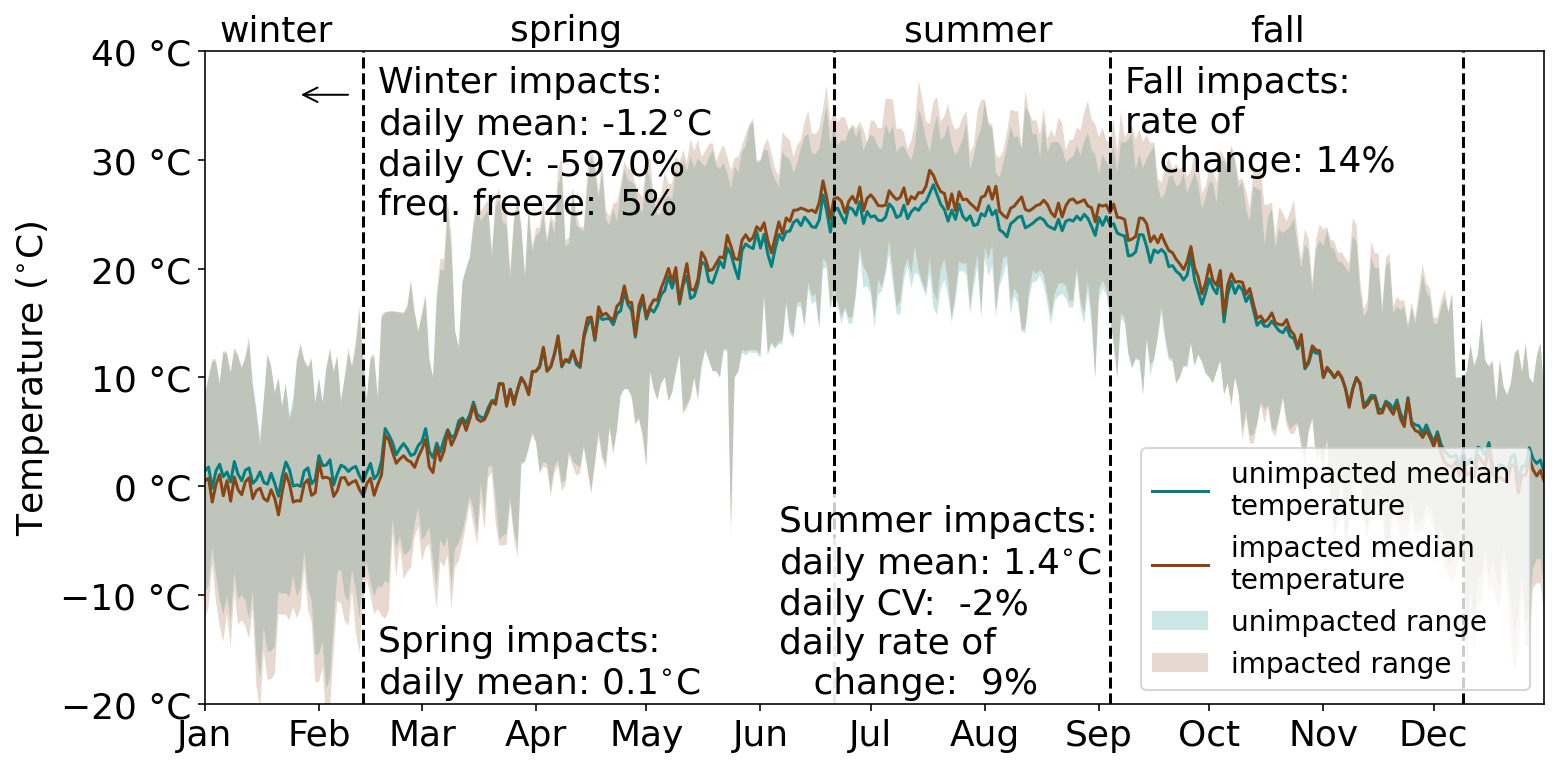

In [73]:
# plot example impacts for one site

site_num = '5370000'
window_size = 5000

fs = 118
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': fs})

flow_data = pd.read_csv(litrev_dir+'streamflow_data/'+site_num+'.csv')
flow_data = flow_data.reset_index()
flow_data['datetime'] = pd.to_datetime(flow_data.datetime)
if flow_data.datetime.iloc[0].month>1 or flow_data.datetime.iloc[0].day>1:
    start_date = pd.to_datetime('1-1-'+str(flow_data.datetime.iloc[0].year))
    length = flow_data.datetime.iloc[0]-start_date
    datetimelist = pd.date_range(start_date, periods=length.days).tolist()
    data = {'datetime': datetimelist, 'discharge_cmd': [np.nan]*len(datetimelist)}
    empty_df = pd.DataFrame.from_dict(data)
    flow_data = pd.concat([empty_df,flow_data],sort=False)
flow_data = flow_data.set_index('datetime')
flow_data['air_temp'] = flow_data.merge(air_temp,left_index=True,right_index=True,how='left').TMAX.ffill()


baseflow,quickflow = fixed_interval_filter(flow_data.discharge_cmd,window_size)
flow_data['baseflow'] = baseflow
flow_data['quickflow'] = quickflow
flow_data['guess_temp'] = (flow_data.baseflow*baseflow_temp+flow_data.quickflow.mul(flow_data.air_temp,axis=0))
flow_data['guess_temp'] = flow_data.guess_temp.mul(1/flow_data.discharge_cmd,axis=0)

# pick pump rate as 1.25 times baseflow median
pump_rate = np.nanmedian(flow_data.baseflow)*1.25
pumprate_diff = abs(pump_range-pump_rate)
pump_rate = pump_rates[list(pumprate_diff).index(min(pumprate_diff))]

impacts = pd.read_csv(litrev_dir+'pump_impacts/'+str(pump_rate)+'_impacts.csv').drop(columns=['Unnamed: 0','times'])
flow_data = (flow_data.reset_index().merge(impacts,left_index=True,right_index=True)).set_index('datetime')
flow_data['discharge_impact'] = flow_data.discharge_cmd-flow_data.Qs
baseflow_impact,quickflow_impact = fixed_interval_filter(flow_data.discharge_impact,window_size)
flow_data['baseflow_impact'] = baseflow_impact
flow_data['quickflow_impact'] = quickflow_impact
flow_data['impact_temp'] = (flow_data.baseflow_impact*baseflow_temp+flow_data.quickflow_impact.mul(flow_data.air_temp,axis=0))
flow_data['impact_temp'] = flow_data.impact_temp.mul(1/flow_data.discharge_impact,axis=0)

flow_data = flow_data.sort_index()
impacts = calc_metrics(flow_data)
flow_data = flow_data.reset_index()[(flow_data.reset_index().datetime.dt.month!=2)|(flow_data.reset_index().datetime.dt.day!=29)].set_index('datetime')

flow_data['date'] = np.where(flow_data.reset_index().datetime.dt.month>=1,
                             flow_data.reset_index()['datetime'].apply(lambda x: x.replace(year = 1999)),
                             flow_data.reset_index()['datetime'].apply(lambda x: x.replace(year = 1999)))
flow_data1 = flow_data.set_index('date').sort_index()

seasons = calc_season_dates(flow_data1.guess_temp.resample('D').mean())

fs = 18
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': fs})
from matplotlib.ticker import EngFormatter
from matplotlib.dates import DateFormatter

impactcolor = 'saddlebrown'#'firebrick'
basecolor = 'teal'#'steelblue'

fig,ax = plt.subplots(1,figsize=(12,6))#(16,6))
ax.plot(flow_data1['guess_temp'].resample('D').median(),label='unimpacted median \ntemperature',c=basecolor)
ax.plot(flow_data1['impact_temp'].resample('D').median(),label='impacted median \ntemperature',c=impactcolor)
ax.fill_between(flow_data1.resample('D').mean().index,flow_data1.guess_temp.resample('D').min(),
               flow_data1.guess_temp.resample('D').max(),alpha=0.2,zorder=-2,label='unimpacted range',facecolor=basecolor)
ax.fill_between(flow_data1.resample('D').mean().index,flow_data1.impact_temp.resample('D').min(),
               flow_data1.impact_temp.resample('D').max(),alpha=0.2,zorder=-1,label='impacted range',facecolor=impactcolor)
for i in range(len(seasons)):
    ax.axvline(seasons[i],c='k',linestyle='--')
plt.plot([seasons[1],seasons[1]],[-25,-5],c='white',linewidth=3,alpha=0.6)

ax.set_ylim(-20,40)
ax.set_xlim(pd.to_datetime('1-1-1999'),pd.to_datetime('12-31-1999'))
ax.legend(loc='lower right',fontsize = 14)
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°C"))
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
ax.set_ylabel('Temperature ($^{\circ}$C)',fontsize = fs)
plt.plot([seasons[1],seasons[1]],[-20,-1],linewidth=3,c='white',alpha=0.8)


ax.text(pd.to_datetime('3-25-1999'),41,'spring',fontsize = fs)
ax.text(pd.to_datetime('7-10-1999'),41,'summer',fontsize = fs)
ax.text(pd.to_datetime('10-12-1999'),41,'fall',fontsize = fs)
ax.text(pd.to_datetime('1-5-1999'),41,'winter',fontsize = fs)


ax.text(pd.to_datetime('2-17-1999'),-19,'Spring impacts:\ndaily mean: %3.1f' %impacts['spring_mean_daily']+'$^{\circ}$C',#+
       fontsize=fs)
ax.text(pd.to_datetime('2-17-1999'),25,'Winter impacts:\ndaily mean: %3.1f' %impacts['winter_mean_daily']+'$^{\circ}$C'+
       '\ndaily CV: %3.0f' %impacts['winter_CV']+'%'+'\nfreq. freeze: %2.0f' %impacts['winter_freq_freeze']+'%'#+
        ,fontsize=fs)
ax.text(pd.to_datetime('6-6-1999'),-19,'Summer impacts:\ndaily mean: %3.1f' %impacts['summer_mean_daily']+'$^{\circ}$C'+
       '\ndaily CV: %3.0f' %impacts['summer_CV']+'%'+
       '\ndaily rate of \n   change: %2.0f'%impacts['summer_median_daily_roc']+'%'#+'\nmax. date: %3.0f'%impacts['summer_max_date']+' days'#+
        ,fontsize=fs)
ax.text(pd.to_datetime('9-8-1999'),29,'Fall impacts:\nrate of \n   change: %1.0f' %impacts['fall_roc']+'%',#+
        fontsize=fs)
ax.annotate("", xy=(pd.to_datetime('1-26-1999'), 36), 
            xytext=(pd.to_datetime('2-10-1999'), 36), 
            arrowprops=dict(arrowstyle="->"))
